## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [61]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%config InlineBackend.figure_format='retina'

from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Create global variables

In [16]:
cameraMatrix = None
distortionCoeffs = None

threshold = None
perspective = None

# Camera calibration

In [17]:

def calibration(path_to_images):
    """
    Given a set of images (checerboards with 9x6 internal points), this
    will create the cameraMatrix and distoritionCoefficients that will
    be used to undistort the image.
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path_to_images)

    # Step through the list and search for chessboard corners
    gray_shape = None
    for fname in images:
        # open and convert to grayscale
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray_shape = gray.shape

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # calibrate the camera and return the cameraMatrix and distortionCoefficients
    ret, mtx, distortion, _, _ =  cv2.calibrateCamera(objpoints,
                                                      imgpoints,
                                                      gray_shape[::-1],
                                                      None, None)
    return mtx, distortion

#
# The cameraMatrix and distortionCoeffs are used when undistorting images
#
cameraMatrix, distortionCoeffs = calibration('./camera_cal/calibration*.jpg')

# Undistort  images


In [18]:
def undistortImage(image):
    """
    Given the cameraMatrix and the distortionCoefficients generated by the
    calibration() function, this will undistort the image.
    """
    assert cameraMatrix is not None, "calibration() not run"
    assert distortionCoeffs is not None, "calibration() not run"

    return cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)

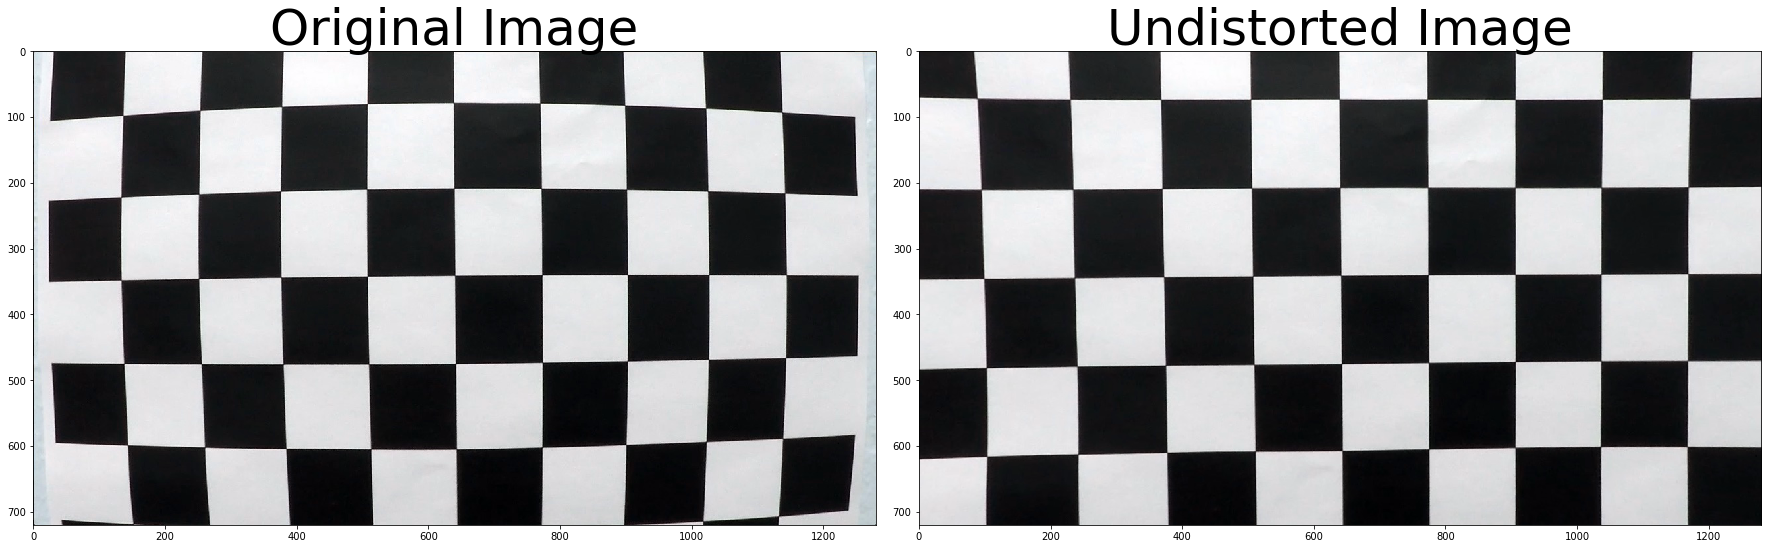

In [19]:
images = ['./camera_cal/calibration1.jpg']
img = cv2.imread(images[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortImage(img))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('calibration.png')

# Create a thresholded image 

In [20]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=(3,3), thresh=(0,255)):
    """
    Creates a filter, based on the Sobel operator, in either the x or y axis,
    depending on the orient parameter.    
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_mask
    
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Creates a binary mask of an image based on the direction of the gradient.
    The size of the kernel is controlled by the sobel_kernel parameter.
    The lower and upper bounds for the thresholding is set by the thresh parameter.
    """
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_mask = np.zeros_like(abs_sobelx)
    binary_mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_mask

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    """
    Creates a binary mask of the image based on the magnitude of the gradient,
    in both the x and y directions.
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    dist = np.sqrt(sobelx*sobelx + sobely*sobely)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * dist / np.max(dist))

    # 5) Create a binary mask where mag thresholds are met
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_mask



# Thresholding pipeline

## Exploratory work

In [50]:
# test1 - bridge
img_original = mpimg.imread('./test_images/test2.jpg')
# test4 - in shadow
img_original = mpimg.imread('./test_images/test5.jpg')
#img_original = mpimg.imread('./test_images/straight_lines2.jpg')

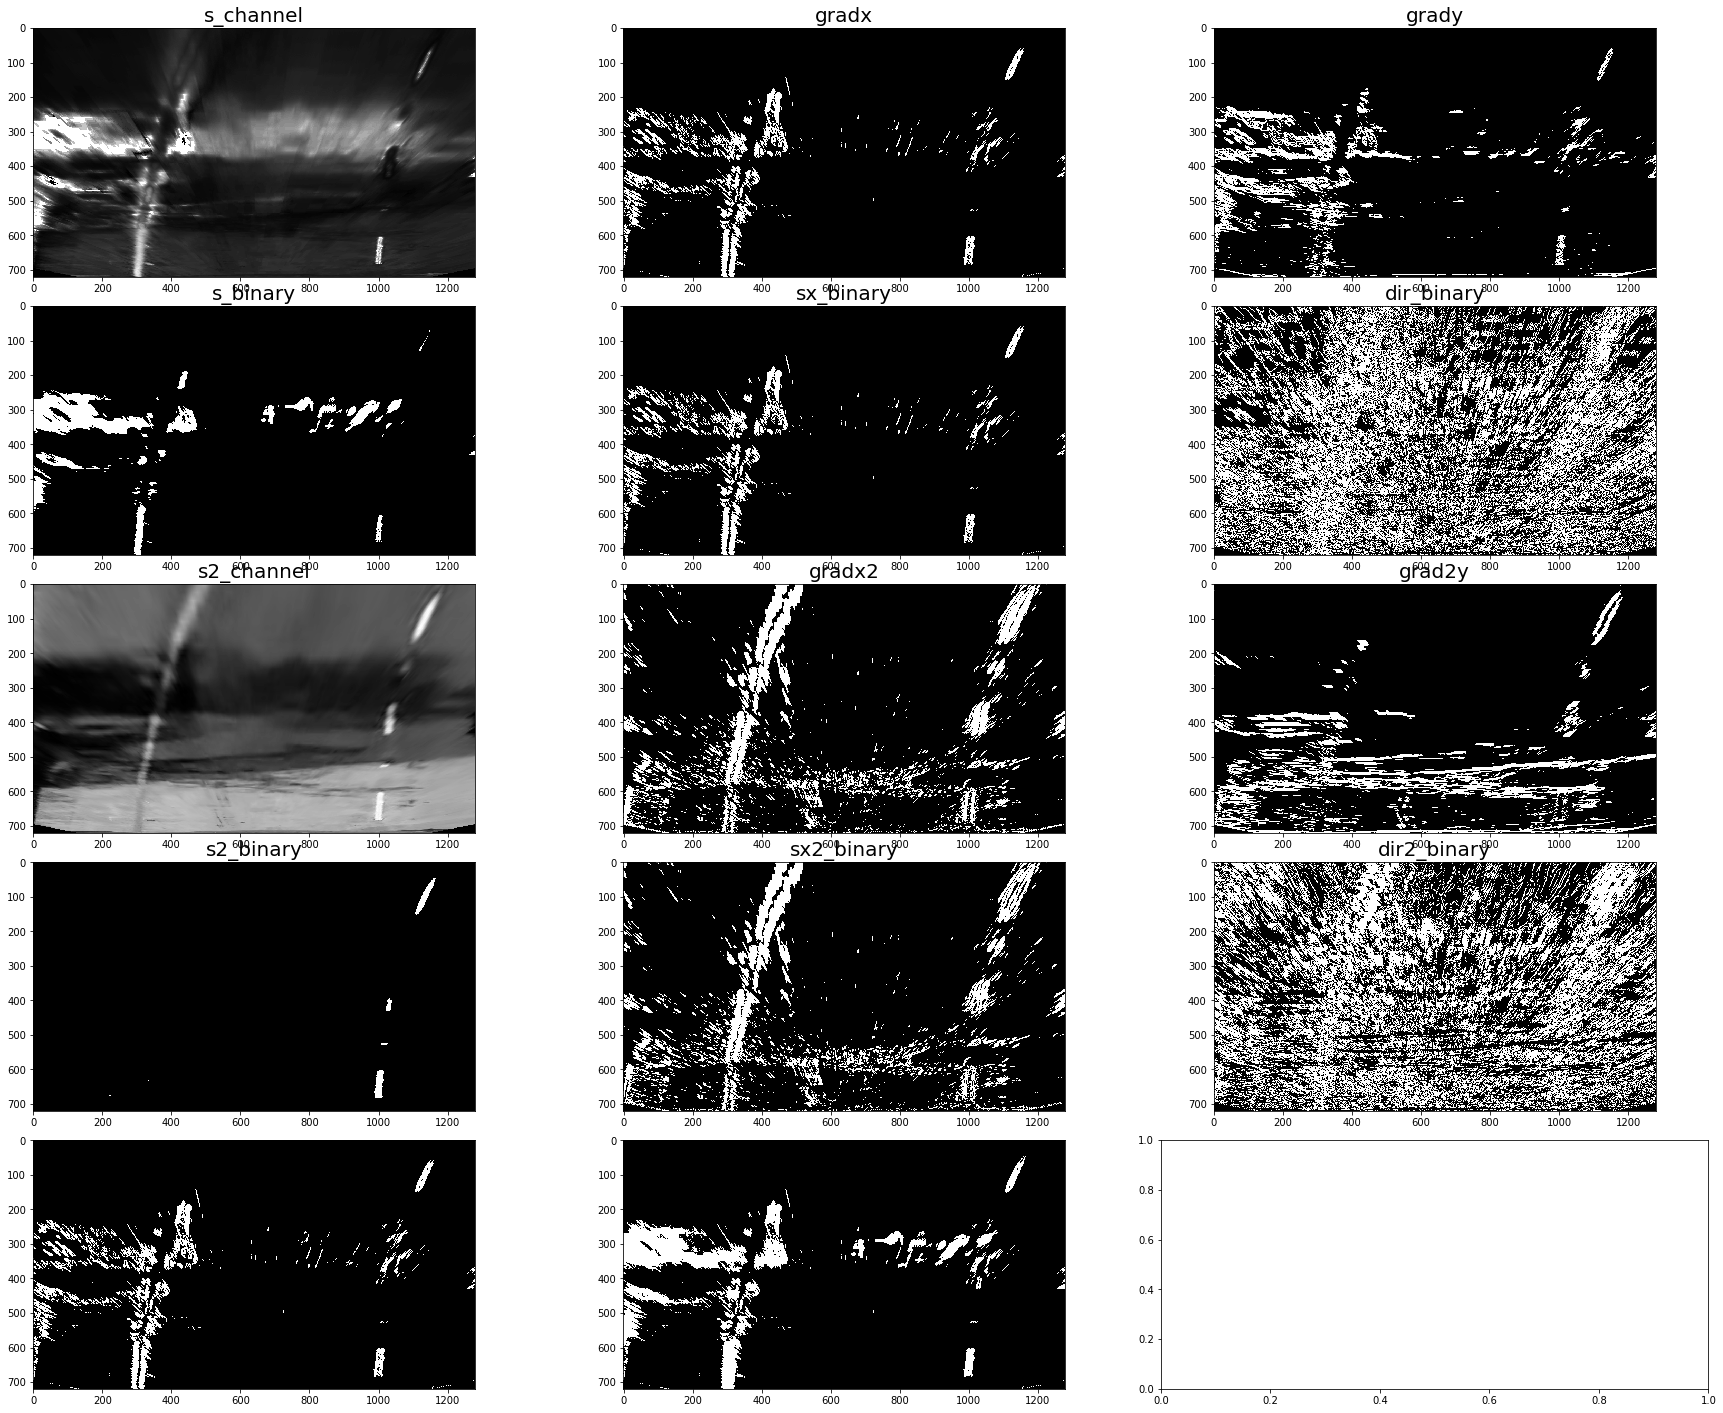

In [67]:
s_thresh = (10, 120)
color_thresh= (150, 255)
ksize=5
img = np.copy(img_original)
img = perspective.warp(img)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:, :, 0]
l_channel = hls[:, :, 1]
s_channel = hls[:, :, 2]

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
h2_channel = hls[:, :, 0]
s2_channel = hls[:, :, 1]
v2_channel = hls[:, :, 2]

sx_binary = abs_sobel_thresh(s_channel, sobel_kernel=5, thresh=(10, 120))

dir_binary = dir_threshold(s_channel, sobel_kernel=3, thresh=(0.2, 1.3))
gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(10,250))
grady = abs_sobel_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(10,250))
mag_binary = mag_thresh(s_channel, sobel_kernel=ksize, thresh=(5, 180))

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 150) & (s_channel <= 255)] = 1


sx2_binary = abs_sobel_thresh(s2_channel, sobel_kernel=5, thresh=(10, 120))

dir2_binary = dir_threshold(s2_channel, sobel_kernel=3, thresh=(0.2, 1.3))
gradx2 = abs_sobel_thresh(s2_channel, orient='x', sobel_kernel=ksize, thresh=(10,250))
grady2 = abs_sobel_thresh(s2_channel, orient='y', sobel_kernel=ksize, thresh=(10,250))
mag2_binary = mag_thresh(s2_channel, sobel_kernel=ksize, thresh=(5, 180))

s2_binary = np.zeros_like(s2_channel)
s2_binary[(s2_channel >= 200) & (s2_channel <= 255)] = 1



f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (c1, c2, c3)) = plt.subplots(5, 3, figsize=(24, 21))
f.tight_layout()
#ax1.imshow(h_channel, cmap='gray')
#ax2.imshow(s_channel, cmap='gray')
#ax3.imshow(l_channel, cmap='gray')
#ax4.imshow(h2_channel, cmap='gray')
#ax5.imshow(s2_channel, cmap='gray')
#ax6.imshow(v2_channel, cmap='gray')
ax1.imshow(s_channel, cmap='gray')
ax1.set_title('s_channel', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('gradx', fontsize=20)
ax3.imshow(grady, cmap='gray')
ax3.set_title('grady', fontsize=20)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('s_binary', fontsize=20)
ax5.imshow(sx_binary, cmap='gray')
ax5.set_title('sx_binary', fontsize=20)
ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('dir_binary', fontsize=20)

ax7.imshow(s2_channel, cmap='gray')
ax7.set_title('s2_channel', fontsize=20)
ax8.imshow(gradx2, cmap='gray')
ax8.set_title('gradx2', fontsize=20)
ax9.imshow(grady2, cmap='gray')
ax9.set_title('grad2y', fontsize=20)
ax10.imshow(s2_binary, cmap='gray')
ax10.set_title('s2_binary', fontsize=20)
ax11.imshow(sx2_binary, cmap='gray')
ax11.set_title('sx2_binary', fontsize=20)
ax12.imshow(dir2_binary, cmap='gray')
ax12.set_title('dir2_binary', fontsize=20)

combined1 = np.zeros_like(s_binary)
combined1[(gradx == 1) | (grady == 1) & (dir_binary == 1) & (s_binary == 1)] = 1

combined2 = np.zeros_like(s_binary)
combined2[((s_binary == 1) | (gradx == 1)) | (s2_binary == 1) & (gradx2 == 1)] = 1


c1.imshow(combined1, cmap='gray')
c2.imshow(combined2, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/threshold_test.png', dpi=300)

## Final thresholding

In [23]:
class ThresholdTransform(object):
    def create_thresholded_image(self, image):
        img = np.copy(image)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hsv[:, :, 2]

        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hls[:, :, 2]

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        s2_channel = hls[:, :, 1]

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= 120) & (s_channel <= 255)] = 1

        gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=5, thresh=(10,250))

        s2_binary = np.zeros_like(s2_channel)
        s2_binary[(s2_channel >= 200) & (s2_channel <= 255)] = 1


        combined = np.zeros_like(s_binary)
        combined[((s_binary == 1) | (gradx == 1)) | (s2_binary == 1)] = 1

        return combined
    
threshold = ThresholdTransform()

# Perspective transform

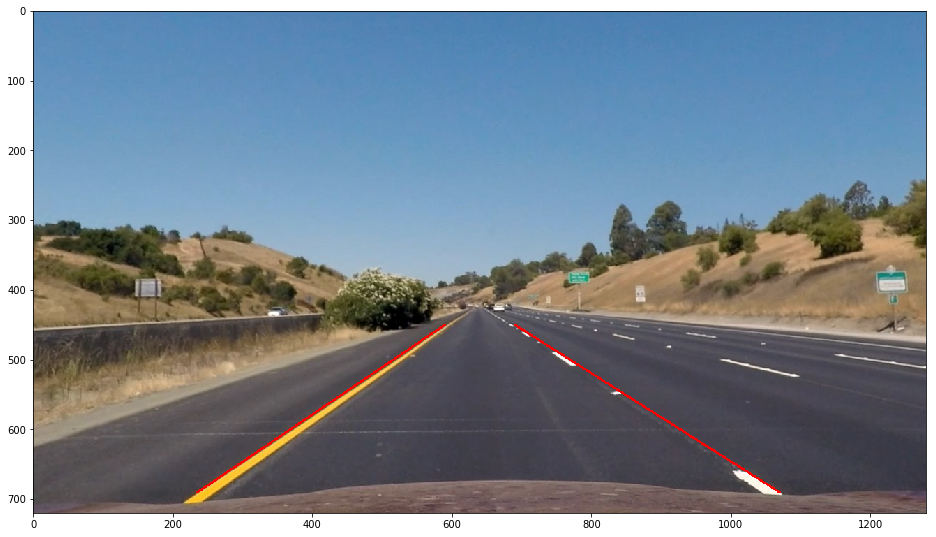

In [48]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
undistorted_image = undistortImage(img)

line1 = [ (235, 690), (590, 450) ]
line2 = [ (1070, 690), (690, 450) ]

cv2.line(undistorted_image, line1[0], line1[1], [255, 0, 0], 2)
cv2.line(undistorted_image, line2[0], line2[1], [255, 0, 0], 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(undistorted_image)
plt.savefig('perspective_transform.png')

In [25]:
img.shape
img_size = (img.shape[1], img.shape[0])

class PerspectiveTransform(object):
    def __init__(self, src_points, dest_points):
        self.M = cv2.getPerspectiveTransform(src_points, dest_points)
        self.Minv = cv2.getPerspectiveTransform(dest_points, src_points)
        
    def warp(self, image):
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)


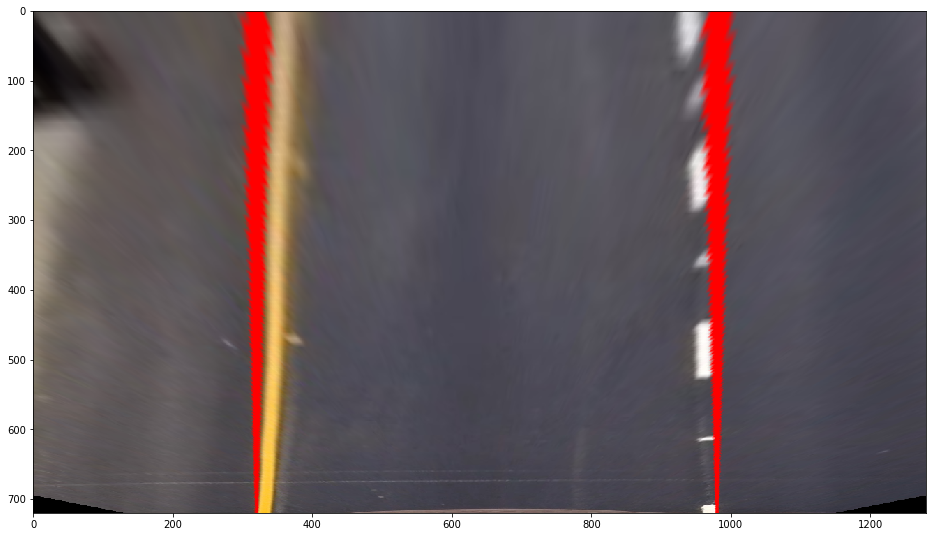

In [26]:
src_points = np.float32([
    line1[1], # upper left
    line2[1], # upper right
    line2[0], # bottom right
    line1[0], # bottom left
])

dest_points = np.float32([
    (320, 0),
    (980, 0),
    (980, 720),
    (320, 720)
])

perspective = PerspectiveTransform(src_points, dest_points)
warped = perspective.warp(undistorted_image)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(warped)

## Detect lane pixels

### Generate thresholded and transformed image

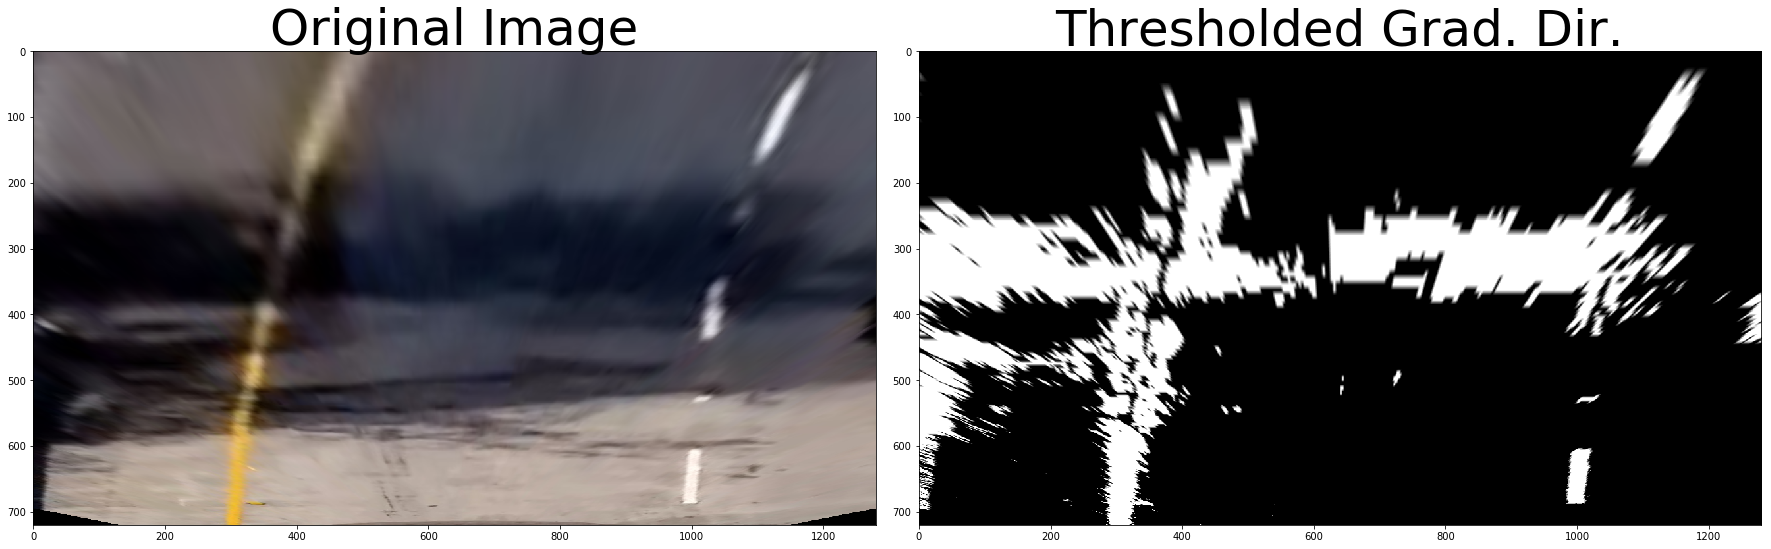

In [14]:
assert threshold is not None, "ThresholdTransform() not created"

img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread('./test_images/test5.jpg')
undistorted_image = undistortImage(img)


warped_original = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(undistorted_image)
thresholded_and_warped = perspective.warp(thresholded_image)

#warped_original = perspective.warp(undistorted_image)
#thresholded_and_warped = threshold.create_thresholded_image(warped_original)
#plt.imshow(warped, cmap='gray')
#thresholded_image = threshold.create_thresholded_image(warped_original)
#warped = perspective.warp(thresholded_image)
#warped = np.copy(thresholded_image)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_and_warped, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

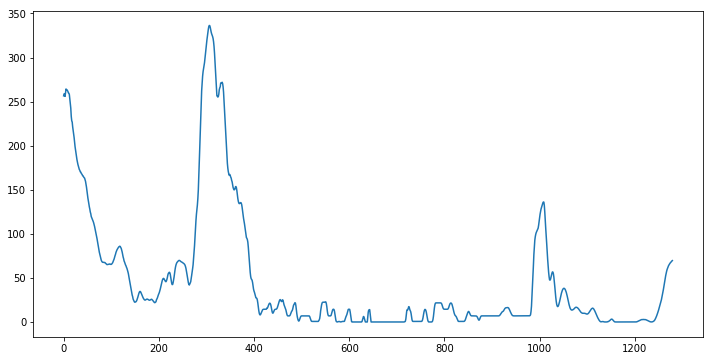

In [15]:
image = thresholded_and_warped
histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.plot(histogram)

In [16]:
binary_warped = np.copy(warped)

# Take histogram of bottom half of image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# create output image to draw on
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find peaks of the histogram for the left and right sides
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("lefx={0} rightx={1}".format(leftx_base, rightx_base))

nz = image.nonzero()
print("len(nzx) = {0}".format(len(nz[0])))
print("len(nzy) = {0}".format(len(nz[1])))

lefx=960 rightx=1660
len(nzx) = 214011
len(nzy) = 214011


In [55]:
#
#

def evaluate_poly(coeffs, pts):
    return coeffs[0]*(pts**2) + coeffs[1]*pts + coeffs[2]


class PolynomialFitting(object):
    """
    Fit the lane lines in an image to a polynomial
    with sliding windows.
    """

    def __init__(self, num_windows=9, margin=100, minpix=50):
        self.num_windows = num_windows
        self.margin = margin
        self.minpix = minpix
        self.lane_center = None

    def fit_to_image(self, image):
        image = np.copy(image)
        # take histogram of bottom half of image
        histogram = np.sum(image[image.shape[0]//2:, :], axis=0)

        # Find the peak of left/right halves of image
        midpoint = np.int(histogram.shape[0]/2)
        base = (np.argmax(histogram[:midpoint]),
                np.argmax(histogram[midpoint:]) + midpoint)
        self.lane_center = (base[0], base[1])

        window_height = np.int(image.shape[0]/self.num_windows)

        # identify x,y positions of all nonzero pixels
        nonzero = image.nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        # current position
        current = list(base)

        left_lane_indices = []
        right_lane_indices= []
        
        left_windows = list()
        right_windows = list()

        for window in range(self.num_windows):
            # identify window boundaries (low, high)
            win_y = (image.shape[0] - (window+1)*window_height,
                     image.shape[0] - window*window_height)
            win_xleft = (current[0] - self.margin,
                         current[0] + self.margin)
            win_xright = (current[1] - self.margin,
                          current[1] + self.margin)

            # draw the windows on the output_image
            left_windows.append( [ (win_xleft[0], win_y[0]), (win_xleft[1], win_y[1]) ])
            right_windows.append( [ (win_xright[0], win_y[0]), (win_xright[1], win_y[1]) ] )

            # identify the nonzero pixels within the window
            good_left_indices = ((nonzeroy >= win_y[0]) &
                                 (nonzeroy <  win_y[1]) &
                                 (nonzerox >= win_xleft[0]) &
                                 (nonzerox <  win_xleft[1])).nonzero()[0]
            good_right_indices = ((nonzeroy >= win_y[0]) &
                                  (nonzeroy <  win_y[1]) &
                                  (nonzerox >= win_xright[0]) &
                                  (nonzerox <  win_xright[1])).nonzero()[0]

            # append indices to the lists
            left_lane_indices.append(good_left_indices)
            right_lane_indices.append(good_right_indices)
    
            # recenter if needed (if > minpix)
            if len(good_left_indices) > self.minpix:
                current[0] = np.int(np.mean(nonzerox[good_left_indices]))
            if len(good_right_indices) > self.minpix:
                current[1] = np.int(np.mean(nonzerox[good_right_indices]))


        # save windows
        self.left_windows = left_windows
        self.right_windows = right_windows
        
        # concatenate the arrays
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)

        # extract left and right lane pixel positions
        self.leftx = nonzerox[left_lane_indices]
        self.lefty = nonzeroy[left_lane_indices]
        self.rightx = nonzerox[right_lane_indices]
        self.righty = nonzeroy[right_lane_indices]

        # fit a second-order polynomial
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)


    def left_poly(self, y):
        return evaluate_poly(self.left_fit, y)

    def right_poly(self, y):
        return evaluate_poly(self.right_fit, y)
    
    def next_image_fit(self, image):
        """
        Tries to fit the current fit to the new image.
        This does not actually update the current values in this object,
        but returns an object that can be used to update this object.
        """
        nonzero = image.nonzero()    
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        left_eval = self.left_poly(nonzeroy)
        right_eval = self.right_poly(nonzeroy)

        left_lane_indices = ((nonzerox > (left_eval - self.margin)) & (nonzerox < (left_eval + self.margin)))
        right_lane_indices = ((nonzerox > (right_eval - self.margin)) & (nonzerox < (right_eval + self.margin)))

        # Extract left and right pixel positions
        leftx = nonzerox[left_lane_indices]
        lefty = nonzeroy[left_lane_indices]
        rightx = nonzerox[right_lane_indices]
        righty = nonzeroy[right_lane_indices]

        if len(lefty) == 0 or len(righty) == 0:
            return { "error" : "could not find any points"}

        # Fit to a 2nd order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Find the lane center from the image
        left_center = np.sum(leftx) / len(leftx)
        right_center = np.sum(rightx) / len(rightx)

        # Find the peak of left/right halves of image
        # Calculate the center of the two peaks
        center = (left_center, right_center)

        return {
            "leftx" : leftx,
            "lefty" : lefty,
            "rightx" : rightx,
            "righty" : righty,
            "left_fit" : left_fit,
            "right_fit" : right_fit,
            "center" : (left_center, right_center)
        }

    def update(self, data):
        self.left_windows = []
        self.right_windows = []

        self.leftx = data['leftx']
        self.lefty = data['lefty']
        self.rightx = data['rightx']
        self.righty = data['righty']
        self.left_fit = data['left_fit']
        self.right_fit = data['right_fit']
        
        self.lane_center = data['center']


In [56]:
def plot_rectangle(plt, coords, color, width=2):
    pt1, pt2 = coords[0], coords[1]
    plt.vlines(pt1[0], pt1[1], pt2[1], colors=color)
    plt.vlines(pt2[0], pt1[1], pt2[1], colors=color)
    plt.hlines(pt1[1], pt1[0], pt2[0], colors=color)
    plt.hlines(pt2[1], pt1[0], pt2[0], colors=color)

(720, 0)

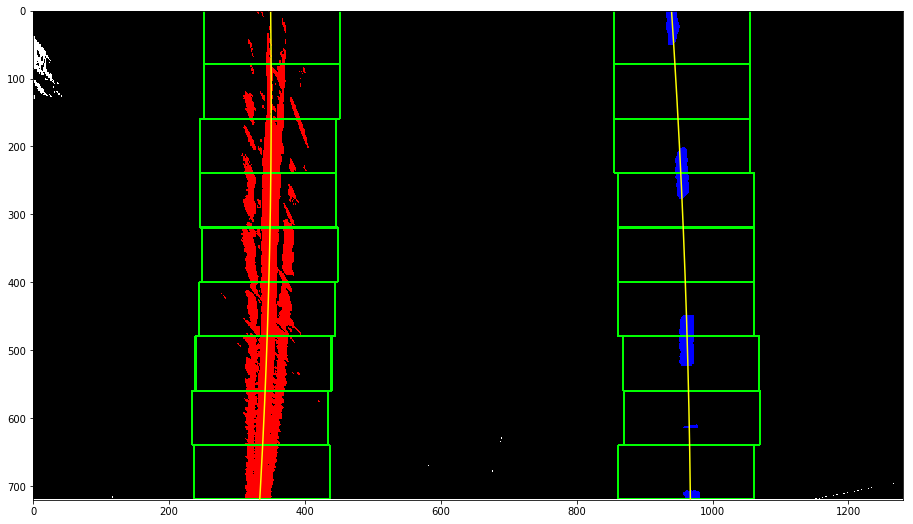

In [58]:
threshold = ThresholdTransform()

img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
undistorted_image = undistortImage(img)
warped = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(warped)


binary_warped = np.copy(thresholded_image)
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
pfit.fit_to_image(binary_warped)

# generate x,y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = pfit.left_poly(ploty)
right_fitx = pfit.right_poly(ploty)

out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255

out_img[pfit.lefty, pfit.leftx] = [255, 0, 0]
out_img[pfit.righty, pfit.rightx] = [0, 0, 255]

for window in pfit.left_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)
for window in pfit.right_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skipping some windows using previous knowledge

(720, 0)

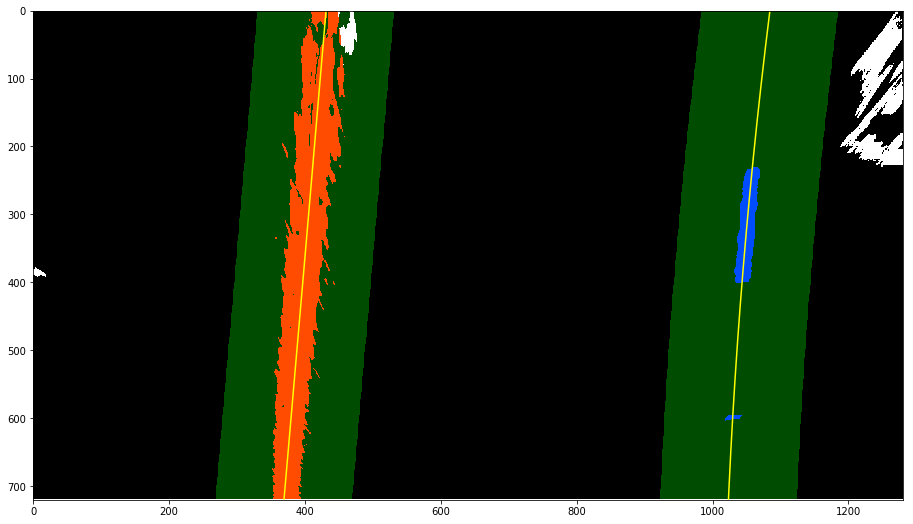

In [86]:
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)

# undistort, warp, and threshold first image
image = mpimg.imread('./test_images/test2.jpg')
undistorted_image = undistortImage(image)
warped = perspective.warp(undistorted_image)
binary_warped = threshold.create_thresholded_image(warped)
pfit.fit_to_image(binary_warped)

# undistort, warp, and threshold second image
next_image = mpimg.imread('./test_images/test6.jpg')
next_undistorted_image = undistortImage(next_image)
next_warped = perspective.warp(next_undistorted_image)
next_binary_warped = threshold.create_thresholded_image(next_warped)

# fit the next image
pfit.update(pfit.next_image_fit(next_binary_warped))

# Generate new x, y positions for plotting
ploty = np.linspace(0, next_binary_warped.shape[0]-1, next_binary_warped.shape[0])
left_fitx = pfit.left_poly(ploty)
right_fitx = pfit.right_poly(ploty)

out_img = np.uint8(np.dstack((next_binary_warped, next_binary_warped, next_binary_warped)))*255
window_img = np.zeros_like(out_img)

# color in left/right pixels
out_img[pfit.lefty, pfit.leftx] = [255, 0, 0]
out_img[pfit.righty, pfit.rightx] = [0, 0, 255]

# generate a polygon to illustrate the search window area
# and recast the x and y points into usable format for cv2.fillPoly()
left_window1 = np.array([np.transpose(np.vstack([left_fitx-pfit.margin, ploty]))])
left_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+pfit.margin, ploty])))])
left_pts = np.hstack((left_window1, left_window2))
right_window1 = np.array([np.transpose(np.vstack([right_fitx-pfit.margin, ploty]))])
right_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+pfit.margin, ploty])))])
right_pts = np.hstack((right_window1, right_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_pts]), (0, 255, 0))
cv2.fillPoly(window_img, np.int_([right_pts]), (0, 255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Radius of curvature calculations

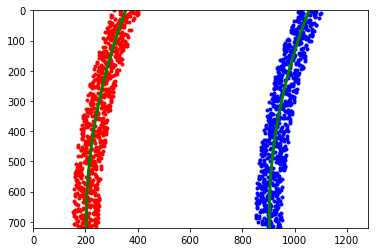

In [4]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [5]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)


1616.62565134 1504.98997663


In [6]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

530.817304515 m 493.710047016 m


In [87]:

# define conversion from pixel space to meters
ym_per_pix = 30/720  # meters per pixel in the y dimension
xm_per_pix = 3.7/700 # meters per pixel in the x dimension

# fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(pfit.lefty*ym_per_pix, pfit.leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(pfit.righty*ym_per_pix, pfit.rightx*xm_per_pix, 2)

# calculate new radii of curvature
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, right_curverad)

107777.720695 2744.81328911


## Putting it all together

In [9]:
# Create the Line class to hold the information for each line
# To reuse the classes, will also keep the PolynomialFitting class that fits
# both sides

class Line():
    """
    Maintains the information about a line in the lane finding code.
    There should be two instances of this class, one for the left
    side and one for the right side.
    """
    
    def __init__(self, window_size=3):
        # was the line detected in the last iteration?
        #self.detected = False
        
        self.window_size = window_size
        
        # x values of the last n fits of the line
        #self.recent_xfitted = []
        
        # average x values of the fitted line over the last n iterations
        #self.bestx = None
        
        # polynomial coefficients averaged over the last n iterations
        self.current_fit = None
        
        # polynomial coefficients for the last n iterations
        self.recent_fits = []

        # polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]
        
        # radius of curvature of the line in meters (using the best_fit)
        #self.radius_of_curvature = None
        
        # distance in meters of vehicle center from the line
        #self.line_base_pos = None
        
        # difference in fit coefficients from last and new fits
        #self.diffs = np.array([0,0,0], dtype='float')
        
        # x values for detected line pixels
        #self.allx = None
        
        # y values for detected line pixels
        #self.ally = None
        
    def clear(self):
        self.recent_fits = []
        self.current_fit = None
        
    def update(self, coeffs):
        if len(self.recent_fits) >= self.window_size:
            self.recent_fits = self.recent_fits[1:]
        self.recent_fits.append(coeffs)
        
        self.current_fit = np.sum(self.recent_fits, axis=0) / len(self.recent_fits)


In [147]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# preliminaries
#
# The cameraMatrix and distortionCoeffs are used when undistorting images
#
cameraMatrix, distortionCoeffs = calibration('./camera_cal/calibration*.jpg')


line1 = [ (245, 680), (550, 480) ]
line2 = [ (1060, 680), (735, 480) ]

src_points = np.float32([
    line1[1], # upper left
    line2[1], # upper right
    line2[0], # bottom right
    line1[0], # bottom left
])

dest_points = np.float32([
    (320, 0),
    (980, 0),
    (980, 720),
    (320, 720)
])

perspective = PerspectiveTransform(src_points, dest_points)
threshold = ThresholdTransform()
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)


In [59]:
import collections

class LaneFinder():
    def __init__(self, sliding_window_depth=3):
        """
        Performs the processing to determine the two lines (left and right) for the
        traffic lane.
        
        Also maintains the history of the line (for a single lane)
        We do this by keeping the average for the past few windows (determined by
        the sliding_window_depth parameter).
        
        """
        # define conversion from pixel space to meters
        #
        # values for the curvature taken from looking at the warped images
        self.ym_per_pix = 27/720  # meters per pixel in the y dimension
        self.xm_per_pix = 3.7/650 # meters per pixel in the x dimension
      

        self.sliding_window_depth = sliding_window_depth
        self.left_lane = Line(self.sliding_window_depth)
        self.right_lane = Line(self.sliding_window_depth)
        
        # Reset the line fitting after 3 consecutive bad images
        self.bad_images_reset = 3
        
        # Number of times since the last good line
        # This is compared to some threshold value
        #   below the threshold -> reuse current line
        #   over the threshold -> search the image from scratch
        # If this is 0, then the last line was good
        # If this is -1, then the full image will be refreshed
        self.last_good_detected = -1

        self.pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
        
        self.stats = collections.Counter()
        
        # TODO: adjust the image size, for now assume a fixed-size height
        # that is determined by the first time the image is fit
        # This is the maximum y-value for the image, that is the bottom of the image
        self.image_height = None
        self.image_width = None

    def clear_lane_info(self):
        """
        Removes any data set for the right/left lane.
        """
        self.left_lane.clear()
        self.right_lane.clear()

    def update_lane_info(self):
        """
        Updates the line (left and right) information
        """
        self.left_lane.update(self.pfit.left_fit)
        self.right_lane.update(self.pfit.right_fit)
        
        
    def get_lane_coeffs(self):
        # average the coeffs of the lane
        return (np.sum(self.left_lane.best_fit, axis=0) / float(len(self.left_lane.best_fit)),
                np.sum(self.right_lane.best_fit, axis=0) / float(len(self.right_lane.best_fit)))

    def calculate_curvature(self, left_fit, right_fit):
        """
        Calculate the curvature of the left and right lanes.
        """

        y_meters = self.ploty*self.ym_per_pix
        leftx = evaluate_poly(left_fit, self.ploty)
        rightx = evaluate_poly(right_fit, self.ploty)

        # fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(y_meters, leftx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(y_meters, rightx*self.xm_per_pix, 2)

        # calculate new radii of curvature
        y_eval = self.image_height-1
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        return (left_curverad, right_curverad)
    
    def sanity_check(self, data):
        """
        Performs a sanity check on the fitted lines.
        Returns true if the lines are ok.
        Returns false if the lines do not pass the tests and should be rejected.
        """

        # Was there an error with the algorithm?
        if 'error' in data:
            print("sanity check: error: {0}".format(data['error']))
            self.stats['sanity_check::data_error'] += 1
            return False

        centers = data['center']
        
        # Check to see if we are in the center of the lane
        # Reject if we are more than 1.0 meter off-center
        center = (centers[0] + centers[1]) / 2.0
        off_center = (center - (self.image_width/2)) * self.xm_per_pix
        if abs(off_center) > 1.0:
            print("sanity_check failed: image too off center : {0}".format(off_center))
            self.stats['sanity_check::off_center'] += 1
            return False

        # Check that the two lines are roughly parallel
        # Get the curve at 10 different points, they should all be (roughly) the
        # same distance apart
        # Generate the curves, assume that they are most likely to be correct
        # near the bottom, so take that value as a baseline. If the curves
        # at the top are off by more than 2x the bottom distance, then they
        # are too far aprt.
        y = np.linspace(0, self.image_height-1, 10)

        leftx = evaluate_poly(data['left_fit'], y)
        rightx = evaluate_poly(data['right_fit'], y)
        
        bottom_distance = rightx[-1] - leftx[-1]
        
        # check that all distances are < 2*bottom_distance
        is_bottom = (rightx - leftx) > 2*bottom_distance
        if sum(is_bottom) > 1:
            print("sanity check failed: curves are not parallel")
            self.stats['sanity_check::not_parallel'] += 1
            return False
        
        
        # Check that the left/right curvatures are roughly equal
        left_curve, right_curve = self.calculate_curvature(data['left_fit'], data['right_fit'])
        
        # Let's just say that the curvature must be within 2xmin
        min_curve = min(left_curve, right_curve)
        if left_curve > 1.5*min_curve or right_curve > 1.5*min_curve:
            print("sanity check failed: curvatures are too different: {0}".format((left_curve, right_curve)))
            self.stats['sanity_check::curvature_failure'] += 1
            return False
        return True
    
    def determine_fit(self, binary_warped):
        """
        Perform the checks and determine how to use the image (it will
        have been transformed and thresholded).
        
        This implementes the control logic.
        """
        # special case for the very first run through the images
        if self.last_good_detected == -1:
            self.last_good_detected = 0
            self.pfit.fit_to_image(binary_warped)
            
            # This is the maximum y-value of the image (the bottom of the image)
            self.image_height = binary_warped.shape[0]
            self.image_width = binary_warped.shape[1]
            self.ploty = np.linspace(0, self.image_height-1, self.image_height)
            
            self.clear_lane_info()
            self.update_lane_info()
            return

        #
        # Treat this as if data has already been run through the image
        #
        data = self.pfit.next_image_fit(binary_warped)

        #
        # Control logic: what do we do with the results for this image
        #
        if self.sanity_check(data) == False:
            #
            # The sanity check failed, reject this image
            # Keep the current fit (to use to determine the lane)
            #
            self.last_good_detected += 1
            self.stats['sanity_check_failed'] += 1
        else:
            #
            # The sanity check succeeded, so reset the last_good_detected to 0
            #
            self.last_good_detected = 0
            self.stats['sanity_check_passed'] += 1
        
        #
        # Now determine what to do based on the number of
        # consecutive bad images seen
        #
        if self.last_good_detected >= self.bad_images_reset:
            #
            # We've hit the threshold for the number of consecutive
            # bad images in a row.  Do a full reset using the current frame.
            #
            self.last_good_detected = 0
            self.pfit.fit_to_image(binary_warped)

            # Clear the lane info
            self.clear_lane_info()
            self.update_lane_info()

            self.stats['image_full_reset'] += 1
            
        elif self.last_good_detected > 0:
            #
            # We've found a bad image, but it's under the threshold
            # Continue using the previous information
            # Nothing to do, do not update the fit object or lane info
            self.stats['image_skipped'] += 1
            pass

        elif self.last_good_detected == 0:
            #
            # This image is good, update the information
            #
            self.pfit.update(data)            
            self.update_lane_info()
            self.stats['image_ok'] += 1

    def process_image(self, image):
        """
        Process a single video frame
        Returns the final output (image which we draw on)
        """
        undistorted_image = undistortImage(image)
        warped = perspective.warp(undistorted_image)
        binary_warped = threshold.create_thresholded_image(warped)
        
        # Now that the image is ready to be used, run it through
        # the proper logic (sanity checks etc...)
        self.determine_fit(binary_warped)
                
        # ok, at this point the lines should have the proper coefficients
        # so use those to draw the lines on the image
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
        # recast x, y points into usuable format for cv2.fillPoly()
        # Get the average coefficients
        left_coeff, right_coeff = self.left_lane.current_fit, self.right_lane.current_fit
        left_fitx = evaluate_poly(left_coeff, self.ploty)
        right_fitx = evaluate_poly(right_coeff, self.ploty)
    
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
    
        # draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
        # warp the blank back to original image space
        newwarp = perspective.unwarp(color_warp)

        final_img = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        left_curve, right_curve = self.calculate_curvature(self.pfit.left_fit, self.pfit.right_fit)
        cv2.putText(final_img,
                    'radius of curvature = {0:.1f} m'.format((left_curve+right_curve)/2.0),
                    (100, 50), font, 1.0, (255, 255, 255), 2)
        center = (self.pfit.lane_center[0] + self.pfit.lane_center[1]) / 2.0
        off_center = (center - (self.image_width/2)) * self.xm_per_pix
        if off_center > 0:
            off_center_text = "Vehicle is left of center by {0:.1f} m".format(off_center)
        elif off_center < 0:
            off_center_text = "Vehicle is right of center by {0:.1f} m".format(-off_center)
        else:
            off_center_text = ""
            
        cv2.putText(final_img,
                    off_center_text,
                    (100, 100), font, 1.0, (255, 255, 255), 2)
        return final_img
    
lanefinder = LaneFinder(5)

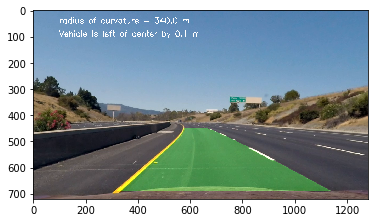

In [62]:
lanefinder = LaneFinder(5)
clip = VideoFileClip('./project_video.mp4')
fps = clip.fps
clip_image = clip.get_frame(100)
out = lanefinder.process_image(clip_image)
left_curve, right_curve = lanefinder.calculate_curvature(lanefinder.pfit.left_fit, lanefinder.pfit.right_fit)
#plt.imshow(out)

clip_image = clip.get_frame(101)
out = lanefinder.process_image(clip_image)
left_curve, right_curve = lanefinder.calculate_curvature(lanefinder.pfit.left_fit, lanefinder.pfit.right_fit)
plt.imshow(out)

In [178]:
lanefinder = LaneFinder(5)
test_output = "./project_output.mp4"
clip1 = VideoFileClip('./project_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:00<03:39,  5.74it/s]






  0%|          | 2/1261 [00:00<03:35,  5.84it/s]






  0%|          | 3/1261 [00:00<03:32,  5.93it/s]






  0%|          | 4/1261 [00:00<03:29,  6.00it/s]






  0%|          | 5/1261 [00:00<03:29,  6.01it/s]






  0%|          | 6/1261 [00:00<03:28,  6.02it/s]






  1%|          | 7/1261 [00:01<03:27,  6.06it/s]






  1%|          | 8/1261 [00:01<03:27,  6.04it/s]






  1%|          | 9/1261 [00:01<03:27,  6.03it/s]






  1%|          | 10/1261 [00:01<03:27,  6.02it/s]






  1%|          | 11/1261 [00:01<03:25,  6.08it/s]






  1%|          | 12/1261 [00:01<03:24,  6.10it/s]






  1%|          | 13/1261 [00:02<03:27,  6.01it/s]






  1%|          | 14/1261 [00:02<03:25,  6.06it/s]






  1%|          | 15/1261 [00:02<03:27,  6.00it/s]






  1%|▏         | 16/1261 [00:02<03:26,  6.02it/s]






  1%|▏         | 17/1261 [00:02<03:26,  6.03it/s]






  1

sanity check failed: curves are not parallel









 49%|████▉     | 616/1261 [01:39<01:41,  6.36it/s]






 49%|████▉     | 617/1261 [01:39<01:39,  6.47it/s]






 49%|████▉     | 618/1261 [01:39<01:38,  6.53it/s]

sanity_check failed: image too off center : -1.630314349271207
sanity_check failed: image too off center : -1.7918453419247156









 49%|████▉     | 619/1261 [01:39<01:40,  6.36it/s]






 49%|████▉     | 620/1261 [01:40<01:38,  6.48it/s]

sanity_check failed: image too off center : -2.199014691125826









 49%|████▉     | 621/1261 [01:40<01:39,  6.41it/s]






 49%|████▉     | 622/1261 [01:40<01:38,  6.48it/s]






 49%|████▉     | 623/1261 [01:40<01:38,  6.45it/s]






 49%|████▉     | 624/1261 [01:40<01:38,  6.45it/s]






 50%|████▉     | 625/1261 [01:40<01:47,  5.92it/s]






 50%|████▉     | 626/1261 [01:41<01:50,  5.75it/s]






 50%|████▉     | 627/1261 [01:41<01:46,  5.94it/s]






 50%|████▉     | 628/1261 [01:41<01:45,  5.98it/s]






 50%|████▉     | 629/1261 [01:41<01:43,  6.09it/s]






 50%|████▉     | 630/1261 [01:41<01:43,  6.10it/s]






 50%|█████     | 631/1261 [01:41<01:41,  6.20it/s]






 50%|█████     | 632/1261 [01:41<01:41,  6.22it/s]






 50%|█████     | 633/1261 [01:42<01:41,  6.17it/s]






 50%|█████     | 634/1261 [01:42<01:40,  6.21it/s]






 50%|█████     | 635/1261 [01:42<01:39,  6.32it/s]






 50%|█████     | 636/1261 [01:42<01:37,  6.38it/s]






 51%|█████     | 637/1261 [01:42<01:37,  6.40it/s]






 51%|█████     | 638/126

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 

CPU times: user 3min 50s, sys: 1min 16s, total: 5min 7s
Wall time: 3min 24s
Counter({'image_ok': 1256, 'sanity_check_passed': 1256, 'sanity_check_failed': 4, 'sanity_check::off_center': 3, 'image_skipped': 3, 'sanity_check::not_parallel': 1, 'image_full_reset': 1})


In [179]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./project_output.mp4'))

In [180]:
lanefinder = LaneFinder(5)
test_output = "./challenge_output.mp4"
clip1 = VideoFileClip('./challenge_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

[MoviePy] >>>> Building video ./challenge_output.mp4
[MoviePy] Writing video ./challenge_output.mp4









  0%|          | 0/485 [00:00<?, ?it/s]






  0%|          | 1/485 [00:00<01:22,  5.84it/s]






  0%|          | 2/485 [00:00<01:20,  5.98it/s]






  1%|          | 3/485 [00:00<01:19,  6.05it/s]






  1%|          | 4/485 [00:00<01:19,  6.06it/s]






  1%|          | 5/485 [00:00<01:17,  6.21it/s]






  1%|          | 6/485 [00:00<01:15,  6.34it/s]






  1%|▏         | 7/485 [00:01<01:15,  6.31it/s]






  2%|▏         | 8/485 [00:01<01:15,  6.28it/s]






  2%|▏         | 9/485 [00:01<01:16,  6.22it/s]






  2%|▏         | 10/485 [00:01<01:15,  6.27it/s]






  2%|▏         | 11/485 [00:01<01:14,  6.39it/s]






  2%|▏         | 12/485 [00:01<01:14,  6.34it/s]






  3%|▎         | 13/485 [00:02<01:14,  6.34it/s]






  3%|▎         | 14/485 [00:02<01:13,  6.42it/s]






  3%|▎         | 15/485 [00:02<01:13,  6.44it/s]






  3%|▎         | 16/485 [00:02<01:14,  6.26it/s]






  4%|▎         | 17/485 [00:02<01:15,  6.22it/s]






  4%|▎         | 18/4

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 32%|███▏      | 155/485 [00:25<00:57,  5.76it/s]

sanity check failed: curves are not parallel









 32%|███▏      | 156/485 [00:25<00:55,  5.92it/s]






 32%|███▏      | 157/485 [00:25<00:54,  5.98it/s]






 33%|███▎      | 158/485 [00:25<00:53,  6.10it/s]






 33%|███▎      | 159/485 [00:26<00:53,  6.10it/s]






 33%|███▎      | 160/485 [00:26<00:53,  6.10it/s]






 33%|███▎      | 161/485 [00:26<00:54,  6.00it/s]






 33%|███▎      | 162/485 [00:26<00:54,  5.96it/s]






 34%|███▎      | 163/485 [00:26<00:54,  5.95it/s]

sanity_check failed: image too off center : -1.0083934994778538
sanity_check failed: image too off center : -1.0157558125457307









 34%|███▍      | 164/485 [00:26<00:55,  5.77it/s]






 34%|███▍      | 165/485 [00:27<00:58,  5.48it/s]

sanity_check failed: image too off center : -1.010645898860375









 34%|███▍      | 166/485 [00:27<00:57,  5.55it/s]






 34%|███▍      | 167/485 [00:27<00:57,  5.54it/s]






 35%|███▍      | 168/485 [00:27<00:57,  5.54it/s]






 35%|███▍      | 169/485 [00:27<00:56,  5.59it/s]






 35%|███▌      | 170/485 [00:28<00:55,  5.65it/s]






 35%|███▌      | 171/485 [00:28<00:54,  5.78it/s]






 35%|███▌      | 172/485 [00:28<00:53,  5.88it/s]






 36%|███▌      | 173/485 [00:28<00:52,  5.94it/s]






 36%|███▌      | 174/485 [00:28<00:53,  5.87it/s]






 36%|███▌      | 175/485 [00:28<00:52,  5.89it/s]






 36%|███▋      | 176/485 [00:29<00:52,  5.91it/s]






 36%|███▋      | 177/485 [00:29<00:52,  5.91it/s]






 37%|███▋      | 178/485 [00:29<00:51,  5.91it/s]






 37%|███▋      | 179/485 [00:29<00:51,  5.90it/s]






 37%|███▋      | 180/485 [00:29<00:50,  5.98it/s]






 37%|███▋      | 181/485 [00:29<00:51,  5.85it/s]






 38%|███▊      | 182/485 [00:30<00:52,  5.75it/s]






 38%|███▊      | 183/485 [00:30<00:51,  5

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 53%|█████▎    | 257/485 [00:42<00:38,  5.90it/s]






 53%|█████▎    | 258/485 [00:42<00:40,  5.66it/s]






 53%|█████▎    | 259/485 [00:43<00:40,  5.64it/s]






 54%|█████▎    | 260/485 [00:43<00:39,  5.66it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 54%|█████▍    | 261/485 [00:43<00:40,  5.56it/s]






 54%|█████▍    | 262/485 [00:43<00:39,  5.60it/s]






 54%|█████▍    | 263/485 [00:43<00:38,  5.72it/s]






 54%|█████▍    | 264/485 [00:43<00:39,  5.62it/s]






 55%|█████▍    | 265/485 [00:44<00:39,  5.53it/s]






 55%|█████▍    | 266/485 [00:44<00:38,  5.69it/s]






 55%|█████▌    | 267/485 [00:44<00:38,  5.64it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 55%|█████▌    | 268/485 [00:44<00:38,  5.59it/s]






 55%|█████▌    | 269/485 [00:44<00:39,  5.54it/s]

sanity check failed: curves are not parallel









 56%|█████▌    | 270/485 [00:44<00:38,  5.57it/s]






 56%|█████▌    | 271/485 [00:45<00:38,  5.58it/s]






 56%|█████▌    | 272/485 [00:45<00:37,  5.66it/s]






 56%|█████▋    | 273/485 [00:45<00:37,  5.71it/s]






 56%|█████▋    | 274/485 [00:45<00:37,  5.64it/s]






 57%|█████▋    | 275/485 [00:45<00:37,  5.58it/s]






 57%|█████▋    | 276/485 [00:46<00:36,  5.69it/s]






 57%|█████▋    | 277/485 [00:46<00:36,  5.64it/s]






 57%|█████▋    | 278/485 [00:46<00:37,  5.56it/s]






 58%|█████▊    | 279/485 [00:46<00:36,  5.59it/s]






 58%|█████▊    | 280/485 [00:46<00:36,  5.61it/s]

sanity_check failed: image too off center : -1.0147470477382587
sanity_check failed: image too off center : -1.0099025381179325









 58%|█████▊    | 281/485 [00:46<00:37,  5.49it/s]

sanity_check failed: image too off center : -1.002194828858383









 58%|█████▊    | 282/485 [00:47<00:36,  5.58it/s]






 58%|█████▊    | 283/485 [00:47<00:36,  5.58it/s]






 59%|█████▊    | 284/485 [00:47<00:35,  5.66it/s]






 59%|█████▉    | 285/485 [00:47<00:34,  5.73it/s]






 59%|█████▉    | 286/485 [00:47<00:34,  5.81it/s]






 59%|█████▉    | 287/485 [00:47<00:33,  5.92it/s]






 59%|█████▉    | 288/485 [00:48<00:33,  5.96it/s]






 60%|█████▉    | 289/485 [00:48<00:33,  5.83it/s]






 60%|█████▉    | 290/485 [00:48<00:33,  5.88it/s]






 60%|██████    | 291/485 [00:48<00:32,  5.89it/s]






 60%|██████    | 292/485 [00:48<00:32,  6.02it/s]






 60%|██████    | 293/485 [00:48<00:32,  5.99it/s]






 61%|██████    | 294/485 [00:49<00:31,  6.03it/s]






 61%|██████    | 295/485 [00:49<00:31,  6.03it/s]






 61%|██████    | 296/485 [00:49<00:31,  6.01it/s]






 61%|██████    | 297/485 [00:49<00:32,  5.78it/s]






 61%|██████▏   | 298/485 [00:49<00:32,  5.72it/s]






 62%|██████▏   | 299/485 [00:50<00:32,  5

sanity_check failed: image too off center : -1.0185091340727774
sanity_check failed: image too off center : -1.006472422197805









 65%|██████▌   | 316/485 [00:52<00:29,  5.77it/s]

sanity_check failed: image too off center : -1.0051179075985615









 65%|██████▌   | 317/485 [00:53<00:28,  5.85it/s]






 66%|██████▌   | 318/485 [00:53<00:28,  5.89it/s]






 66%|██████▌   | 319/485 [00:53<00:28,  5.93it/s]






 66%|██████▌   | 320/485 [00:53<00:27,  5.96it/s]






 66%|██████▌   | 321/485 [00:53<00:27,  5.88it/s]






 66%|██████▋   | 322/485 [00:53<00:27,  5.88it/s]






 67%|██████▋   | 323/485 [00:54<00:28,  5.77it/s]






 67%|██████▋   | 324/485 [00:54<00:28,  5.73it/s]






 67%|██████▋   | 325/485 [00:54<00:28,  5.68it/s]






 67%|██████▋   | 326/485 [00:54<00:27,  5.82it/s]






 67%|██████▋   | 327/485 [00:54<00:27,  5.80it/s]






 68%|██████▊   | 328/485 [00:54<00:27,  5.78it/s]






 68%|██████▊   | 329/485 [00:55<00:27,  5.72it/s]






 68%|██████▊   | 330/485 [00:55<00:26,  5.74it/s]






 68%|██████▊   | 331/485 [00:55<00:26,  5.71it/s]






 68%|██████▊   | 332/485 [00:55<00:26,  5.70it/s]






 69%|██████▊   | 333/485 [00:55<00:26,  5.82it/s]






 69%|██████▉   | 334/485 [00:55<00:26,  5

sanity check failed: curves are not parallel









 73%|███████▎  | 354/485 [00:59<00:23,  5.57it/s]






 73%|███████▎  | 355/485 [00:59<00:24,  5.37it/s]






 73%|███████▎  | 356/485 [00:59<00:23,  5.44it/s]






 74%|███████▎  | 357/485 [00:59<00:22,  5.58it/s]






 74%|███████▍  | 358/485 [01:00<00:22,  5.59it/s]






 74%|███████▍  | 359/485 [01:00<00:21,  5.74it/s]






 74%|███████▍  | 360/485 [01:00<00:21,  5.81it/s]






 74%|███████▍  | 361/485 [01:00<00:20,  5.95it/s]






 75%|███████▍  | 362/485 [01:00<00:20,  6.01it/s]






 75%|███████▍  | 363/485 [01:00<00:20,  5.95it/s]






 75%|███████▌  | 364/485 [01:01<00:20,  5.84it/s]






 75%|███████▌  | 365/485 [01:01<00:20,  5.74it/s]






 75%|███████▌  | 366/485 [01:01<00:20,  5.85it/s]






 76%|███████▌  | 367/485 [01:01<00:19,  5.96it/s]






 76%|███████▌  | 368/485 [01:01<00:19,  6.09it/s]






 76%|███████▌  | 369/485 [01:02<00:19,  5.90it/s]






 76%|███████▋  | 370/485 [01:02<00:19,  5.85it/s]






 76%|███████▋  | 371/485 [01:02<00:19,  5

sanity_check failed: image too off center : -1.0924619156099435
sanity_check failed: image too off center : -1.097678123967452









 81%|████████  | 394/485 [01:06<00:15,  5.71it/s]






 81%|████████▏ | 395/485 [01:06<00:16,  5.54it/s]

sanity_check failed: image too off center : -1.1565009993946476









 82%|████████▏ | 396/485 [01:06<00:15,  5.62it/s]






 82%|████████▏ | 397/485 [01:06<00:15,  5.76it/s]






 82%|████████▏ | 398/485 [01:06<00:14,  5.95it/s]






 82%|████████▏ | 399/485 [01:07<00:14,  5.99it/s]






 82%|████████▏ | 400/485 [01:07<00:13,  6.08it/s]






 83%|████████▎ | 401/485 [01:07<00:13,  6.10it/s]






 83%|████████▎ | 402/485 [01:07<00:13,  6.02it/s]






 83%|████████▎ | 403/485 [01:07<00:13,  6.02it/s]






 83%|████████▎ | 404/485 [01:07<00:13,  6.10it/s]






 84%|████████▎ | 405/485 [01:08<00:13,  6.11it/s]






 84%|████████▎ | 406/485 [01:08<00:12,  6.26it/s]






 84%|████████▍ | 407/485 [01:08<00:12,  6.26it/s]






 84%|████████▍ | 408/485 [01:08<00:12,  6.28it/s]






 84%|████████▍ | 409/485 [01:08<00:12,  6.14it/s]






 85%|████████▍ | 410/485 [01:08<00:12,  6.19it/s]






 85%|████████▍ | 411/485 [01:09<00:11,  6.31it/s]






 85%|████████▍ | 412/485 [01:09<00:11,  6.37it/s]






 85%|████████▌ | 413/485 [01:09<00:11,  6

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_output.mp4 

CPU times: user 1min 30s, sys: 29.1 s, total: 2min
Wall time: 1min 21s
Counter({'image_ok': 462, 'sanity_check_passed': 462, 'sanity_check_failed': 23, 'image_skipped': 17, 'sanity_check::off_center': 12, 'sanity_check::not_parallel': 11, 'image_full_reset': 6})


In [181]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./challenge_output.mp4'))

In [167]:
lanefinder = LaneFinder(5)
test_output = "./harder_challenge_output.mp4"
clip1 = VideoFileClip('./harder_challenge_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)

[MoviePy] >>>> Building video ./harder_challenge_output.mp4
[MoviePy] Writing video ./harder_challenge_output.mp4









  0%|          | 0/1200 [00:00<?, ?it/s]






  0%|          | 1/1200 [00:00<03:57,  5.04it/s]






  0%|          | 2/1200 [00:00<03:49,  5.22it/s]






  0%|          | 3/1200 [00:00<03:41,  5.41it/s]






  0%|          | 4/1200 [00:00<03:33,  5.61it/s]






  0%|          | 5/1200 [00:00<03:31,  5.65it/s]






  0%|          | 6/1200 [00:01<03:33,  5.58it/s]






  1%|          | 7/1200 [00:01<03:31,  5.64it/s]






  1%|          | 8/1200 [00:01<03:29,  5.69it/s]






  1%|          | 9/1200 [00:01<03:25,  5.79it/s]






  1%|          | 10/1200 [00:01<03:23,  5.84it/s]






  1%|          | 11/1200 [00:01<03:23,  5.85it/s]






  1%|          | 12/1200 [00:02<03:20,  5.92it/s]






  1%|          | 13/1200 [00:02<03:24,  5.81it/s]






  1%|          | 14/1200 [00:02<03:27,  5.71it/s]






  1%|▏         | 15/1200 [00:02<03:24,  5.80it/s]






  1%|▏         | 16/1200 [00:02<03:20,  5.90it/s]






  1%|▏         | 17/1200 [00:02<03:16,  6.02it/s]






  2

sanity_check failed: image too off center : -1.0131692229454032









  8%|▊         | 90/1200 [00:15<02:59,  6.17it/s]






  8%|▊         | 91/1200 [00:15<02:57,  6.25it/s]






  8%|▊         | 92/1200 [00:15<02:54,  6.34it/s]






  8%|▊         | 93/1200 [00:15<03:01,  6.09it/s]






  8%|▊         | 94/1200 [00:16<03:06,  5.92it/s]






  8%|▊         | 95/1200 [00:16<03:09,  5.83it/s]






  8%|▊         | 96/1200 [00:16<03:08,  5.86it/s]






  8%|▊         | 97/1200 [00:16<03:08,  5.86it/s]






  8%|▊         | 98/1200 [00:16<03:14,  5.67it/s]






  8%|▊         | 99/1200 [00:16<03:16,  5.61it/s]






  8%|▊         | 100/1200 [00:17<03:15,  5.64it/s]

sanity_check failed: image too off center : -1.0317669927381568
sanity_check failed: image too off center : -1.0081884566010957









  8%|▊         | 101/1200 [00:17<03:20,  5.49it/s]






  8%|▊         | 102/1200 [00:17<03:18,  5.53it/s]






  9%|▊         | 103/1200 [00:17<03:14,  5.63it/s]






  9%|▊         | 104/1200 [00:17<03:09,  5.79it/s]






  9%|▉         | 105/1200 [00:18<03:12,  5.69it/s]






  9%|▉         | 106/1200 [00:18<03:14,  5.61it/s]






  9%|▉         | 107/1200 [00:18<03:14,  5.62it/s]






  9%|▉         | 108/1200 [00:18<03:10,  5.74it/s]






  9%|▉         | 109/1200 [00:18<03:07,  5.81it/s]






  9%|▉         | 110/1200 [00:18<03:06,  5.85it/s]






  9%|▉         | 111/1200 [00:19<03:01,  6.01it/s]

sanity_check failed: image too off center : -1.0041820383762523









  9%|▉         | 112/1200 [00:19<02:59,  6.05it/s]






  9%|▉         | 113/1200 [00:19<02:59,  6.06it/s]






 10%|▉         | 114/1200 [00:19<02:57,  6.10it/s]






 10%|▉         | 115/1200 [00:19<02:55,  6.20it/s]






 10%|▉         | 116/1200 [00:19<02:55,  6.17it/s]






 10%|▉         | 117/1200 [00:20<03:01,  5.97it/s]






 10%|▉         | 118/1200 [00:20<03:07,  5.78it/s]






 10%|▉         | 119/1200 [00:20<03:04,  5.85it/s]






 10%|█         | 120/1200 [00:20<03:06,  5.79it/s]






 10%|█         | 121/1200 [00:20<03:15,  5.52it/s]






 10%|█         | 122/1200 [00:20<03:17,  5.46it/s]






 10%|█         | 123/1200 [00:21<03:12,  5.59it/s]






 10%|█         | 124/1200 [00:21<03:12,  5.60it/s]






 10%|█         | 125/1200 [00:21<03:16,  5.47it/s]






 10%|█         | 126/1200 [00:21<03:09,  5.66it/s]






 11%|█         | 127/1200 [00:21<03:06,  5.76it/s]






 11%|█         | 128/1200 [00:21<03:05,  5.77it/s]






 11%|█         | 129/120

sanity_check failed: image too off center : 1.0058788219431583
sanity_check failed: image too off center : 1.0286293281258598









 12%|█▏        | 149/1200 [00:25<03:04,  5.68it/s]

sanity_check failed: image too off center : 1.05865906799138
sanity_check failed: image too off center : 1.4035422223548526









 12%|█▎        | 150/1200 [00:25<03:00,  5.83it/s]






 13%|█▎        | 151/1200 [00:26<02:58,  5.87it/s]

sanity_check failed: image too off center : 1.415165512700287
sanity_check failed: image too off center : 1.431061717429059









 13%|█▎        | 152/1200 [00:26<03:09,  5.54it/s]






 13%|█▎        | 153/1200 [00:26<03:08,  5.56it/s]

sanity_check failed: image too off center : 1.448391099948049
sanity_check failed: image too off center : 1.463537979121227









 13%|█▎        | 154/1200 [00:26<03:07,  5.59it/s]






 13%|█▎        | 155/1200 [00:26<03:09,  5.50it/s]

sanity_check failed: image too off center : 1.4743298483042697









 13%|█▎        | 156/1200 [00:26<03:10,  5.47it/s]






 13%|█▎        | 157/1200 [00:27<03:06,  5.59it/s]

sanity_check failed: image too off center : 1.5018852325447167
sanity_check failed: image too off center : 1.5290235993487344









 13%|█▎        | 158/1200 [00:27<03:09,  5.49it/s]

sanity_check failed: image too off center : 1.479706926904377
sanity_check failed: image too off center : 1.4460121142977411









 13%|█▎        | 159/1200 [00:27<03:02,  5.70it/s]






 13%|█▎        | 160/1200 [00:27<02:59,  5.81it/s]

sanity_check failed: image too off center : 1.3970104640129488
sanity_check failed: image too off center : 1.3496106472724378









 13%|█▎        | 161/1200 [00:27<03:11,  5.42it/s]






 14%|█▎        | 162/1200 [00:28<03:11,  5.41it/s]

sanity_check failed: image too off center : 1.2998483242588015
sanity_check failed: image too off center : 1.2748836049825452









 14%|█▎        | 163/1200 [00:28<03:11,  5.42it/s]






 14%|█▎        | 164/1200 [00:28<03:10,  5.45it/s]

sanity_check failed: image too off center : 1.240483224542485
sanity_check failed: image too off center : 1.2051570667858182









 14%|█▍        | 165/1200 [00:28<03:06,  5.54it/s]






 14%|█▍        | 166/1200 [00:28<03:06,  5.55it/s]

sanity_check failed: image too off center : 1.1903015439236655
sanity_check failed: image too off center : 1.1617620391501124









 14%|█▍        | 167/1200 [00:28<03:09,  5.44it/s]






 14%|█▍        | 168/1200 [00:29<03:00,  5.71it/s]






 14%|█▍        | 169/1200 [00:29<02:54,  5.91it/s]

sanity_check failed: image too off center : 1.1466346780855223
sanity_check failed: image too off center : 1.1267706047500219









 14%|█▍        | 170/1200 [00:29<02:53,  5.92it/s]






 14%|█▍        | 171/1200 [00:29<02:49,  6.07it/s]

sanity_check failed: image too off center : 1.0888420543152233
sanity_check failed: image too off center : 1.0514881674779428









 14%|█▍        | 172/1200 [00:29<02:45,  6.20it/s]






 14%|█▍        | 173/1200 [00:29<02:47,  6.15it/s]

sanity_check failed: image too off center : 1.0189583367065889
sanity_check failed: image too off center : 1.009499417934388









 14%|█▍        | 174/1200 [00:30<02:45,  6.22it/s]






 15%|█▍        | 175/1200 [00:30<02:46,  6.17it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 15%|█▍        | 176/1200 [00:30<02:57,  5.76it/s]

sanity check failed: curves are not parallel
sanity_check failed: image too off center : 1.017281587515941









 15%|█▍        | 177/1200 [00:30<02:58,  5.72it/s]






 15%|█▍        | 178/1200 [00:30<02:51,  5.95it/s]






 15%|█▍        | 179/1200 [00:30<02:51,  5.94it/s]

sanity_check failed: image too off center : 1.0011055472573445
sanity_check failed: image too off center : 1.0131217581458978









 15%|█▌        | 180/1200 [00:31<02:51,  5.94it/s]






 15%|█▌        | 181/1200 [00:31<02:55,  5.81it/s]






 15%|█▌        | 182/1200 [00:31<02:51,  5.94it/s]

sanity_check failed: image too off center : 1.009869073278907









 15%|█▌        | 183/1200 [00:31<02:48,  6.05it/s]






 15%|█▌        | 184/1200 [00:31<02:42,  6.24it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 15%|█▌        | 185/1200 [00:31<02:41,  6.27it/s]






 16%|█▌        | 186/1200 [00:32<02:34,  6.56it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 16%|█▌        | 187/1200 [00:32<02:32,  6.63it/s]






 16%|█▌        | 188/1200 [00:32<02:41,  6.26it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 16%|█▌        | 189/1200 [00:32<02:48,  6.00it/s]






 16%|█▌        | 190/1200 [00:32<02:53,  5.82it/s]






 16%|█▌        | 191/1200 [00:32<03:00,  5.57it/s]






 16%|█▌        | 192/1200 [00:33<03:03,  5.50it/s]






 16%|█▌        | 193/1200 [00:33<03:06,  5.39it/s]






 16%|█▌        | 194/1200 [00:33<03:06,  5.39it/s]






 16%|█▋        | 195/1200 [00:33<03:06,  5.40it/s]






 16%|█▋        | 196/1200 [00:33<03:02,  5.50it/s]






 16%|█▋        | 197/1200 [00:34<02:59,  5.58it/s]






 16%|█▋        | 198/1200 [00:34<02:57,  5.64it/s]






 17%|█▋        | 199/1200 [00:34<02:56,  5.67it/s]






 17%|█▋        | 200/1200 [00:34<02:53,  5.75it/s]






 17%|█▋        | 201/1200 [00:34<02:53,  5.76it/s]






 17%|█▋        | 202/1200 [00:34<02:52,  5.79it/s]






 17%|█▋        | 203/1200 [00:35<02:57,  5.62it/s]






 17%|█▋        | 204/1200 [00:35<03:01,  5.50it/s]






 17%|█▋        | 205/1200 [00:35<03:00,  5.51it/s]






 17%|█▋        | 206/120

sanity_check failed: image too off center : -1.0685690300076829
sanity_check failed: image too off center : -1.1576372777346493









 17%|█▋        | 208/1200 [00:35<03:00,  5.50it/s]

sanity_check failed: image too off center : -1.2393287766334888









 17%|█▋        | 209/1200 [00:36<03:04,  5.38it/s]






 18%|█▊        | 210/1200 [00:36<03:09,  5.24it/s]






 18%|█▊        | 211/1200 [00:36<03:10,  5.19it/s]






 18%|█▊        | 212/1200 [00:36<03:10,  5.19it/s]






 18%|█▊        | 213/1200 [00:36<03:10,  5.19it/s]






 18%|█▊        | 214/1200 [00:37<03:10,  5.16it/s]






 18%|█▊        | 215/1200 [00:37<03:13,  5.10it/s]






 18%|█▊        | 216/1200 [00:37<03:14,  5.05it/s]






 18%|█▊        | 217/1200 [00:37<03:17,  4.97it/s]






 18%|█▊        | 218/1200 [00:37<03:14,  5.05it/s]






 18%|█▊        | 219/1200 [00:38<03:09,  5.18it/s]






 18%|█▊        | 220/1200 [00:38<03:09,  5.17it/s]






 18%|█▊        | 221/1200 [00:38<03:11,  5.12it/s]






 18%|█▊        | 222/1200 [00:38<03:11,  5.10it/s]






 19%|█▊        | 223/1200 [00:38<03:11,  5.09it/s]






 19%|█▊        | 224/1200 [00:39<03:10,  5.12it/s]






 19%|█▉        | 225/1200 [00:39<03:10,  5.12it/s]






 19%|█▉        | 226/120

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 19%|█▉        | 229/1200 [00:40<03:14,  5.00it/s]

sanity check failed: curves are not parallel









 19%|█▉        | 230/1200 [00:40<03:12,  5.04it/s]






 19%|█▉        | 231/1200 [00:40<03:08,  5.15it/s]






 19%|█▉        | 232/1200 [00:40<03:04,  5.25it/s]






 19%|█▉        | 233/1200 [00:40<03:12,  5.02it/s]






 20%|█▉        | 234/1200 [00:41<03:16,  4.93it/s]






 20%|█▉        | 235/1200 [00:41<03:14,  4.97it/s]






 20%|█▉        | 236/1200 [00:41<03:08,  5.11it/s]






 20%|█▉        | 237/1200 [00:41<03:04,  5.23it/s]






 20%|█▉        | 238/1200 [00:41<03:01,  5.29it/s]






 20%|█▉        | 239/1200 [00:42<02:57,  5.43it/s]






 20%|██        | 240/1200 [00:42<02:54,  5.51it/s]






 20%|██        | 241/1200 [00:42<02:52,  5.55it/s]






 20%|██        | 242/1200 [00:42<02:51,  5.58it/s]






 20%|██        | 243/1200 [00:42<02:50,  5.61it/s]






 20%|██        | 244/1200 [00:42<02:49,  5.63it/s]






 20%|██        | 245/1200 [00:43<02:47,  5.69it/s]






 20%|██        | 246/1200 [00:43<02:49,  5.64it/s]






 21%|██        | 247/120

sanity_check failed: image too off center : 1.137383644180186
sanity_check failed: image too off center : 1.246742705312322









 28%|██▊       | 332/1200 [00:57<02:32,  5.70it/s]

sanity_check failed: image too off center : 1.294585939779694
sanity_check failed: image too off center : 1.4256193270948323








 28%|██▊       | 333/1200 [00:57<02:31,  5.71it/s]






 28%|██▊       | 334/1200 [00:58<02:33,  5.66it/s]


sanity_check failed: image too off center : 1.4224478915106722
sanity_check failed: image too off center : 1.4334740553744776









 28%|██▊       | 335/1200 [00:58<02:40,  5.39it/s]






 28%|██▊       | 336/1200 [00:58<02:43,  5.29it/s]

sanity_check failed: image too off center : 1.3714787406093143
sanity_check failed: image too off center : 1.3594573990049128









 28%|██▊       | 337/1200 [00:58<02:45,  5.22it/s]






 28%|██▊       | 338/1200 [00:58<02:54,  4.93it/s]

sanity_check failed: image too off center : 1.3332071958759881









 28%|██▊       | 339/1200 [00:59<02:50,  5.04it/s]

sanity_check failed: image too off center : 1.328162680233922
sanity_check failed: image too off center : 1.2981023842833173









 28%|██▊       | 340/1200 [00:59<02:49,  5.06it/s]






 28%|██▊       | 341/1200 [00:59<02:57,  4.84it/s]

sanity_check failed: image too off center : 1.2558759861712392









 28%|██▊       | 342/1200 [00:59<02:51,  5.00it/s]

sanity_check failed: image too off center : 1.281784497832444
sanity_check failed: image too off center : 1.2525760436021784









 29%|██▊       | 343/1200 [00:59<02:48,  5.09it/s]






 29%|██▊       | 344/1200 [01:00<02:55,  4.87it/s]

sanity_check failed: image too off center : 1.2390977311540132









 29%|██▉       | 345/1200 [01:00<02:50,  5.01it/s]

sanity_check failed: image too off center : 1.1632465307718494
sanity_check failed: image too off center : 1.145964268574945









 29%|██▉       | 346/1200 [01:00<02:49,  5.04it/s]






 29%|██▉       | 347/1200 [01:00<02:55,  4.87it/s]

sanity_check failed: image too off center : 1.142689045432435









 29%|██▉       | 348/1200 [01:00<02:52,  4.95it/s]

sanity_check failed: image too off center : 1.070593399455909
sanity_check failed: image too off center : 1.0539181227731513








 29%|██▉       | 349/1200 [01:01<02:52,  4.93it/s]






 29%|██▉       | 350/1200 [01:01<02:56,  4.82it/s]


sanity_check failed: image too off center : 1.0371378064691184









 29%|██▉       | 351/1200 [01:01<02:51,  4.94it/s]






 29%|██▉       | 352/1200 [01:01<02:45,  5.11it/s]






 29%|██▉       | 353/1200 [01:01<02:41,  5.26it/s]






 30%|██▉       | 354/1200 [01:02<02:44,  5.13it/s]






 30%|██▉       | 355/1200 [01:02<02:44,  5.13it/s]






 30%|██▉       | 356/1200 [01:02<02:45,  5.11it/s]






 30%|██▉       | 357/1200 [01:02<02:42,  5.19it/s]






 30%|██▉       | 358/1200 [01:02<02:46,  5.06it/s]






 30%|██▉       | 359/1200 [01:03<02:45,  5.07it/s]






 30%|███       | 360/1200 [01:03<02:40,  5.22it/s]

sanity_check failed: image too off center : 1.2237414133401063
sanity_check failed: image too off center : 1.303779562221142









 30%|███       | 361/1200 [01:03<02:47,  5.00it/s]

sanity_check failed: image too off center : 1.4414502234420878









 30%|███       | 362/1200 [01:03<02:44,  5.09it/s]

sanity_check failed: image too off center : 1.4250424199846499









 30%|███       | 363/1200 [01:03<02:48,  4.96it/s]

sanity_check failed: image too off center : 1.3628562696656021









 30%|███       | 364/1200 [01:04<03:00,  4.63it/s]

sanity_check failed: image too off center : 1.3196719490559914









 30%|███       | 365/1200 [01:04<02:51,  4.86it/s]

sanity_check failed: image too off center : 1.0852398311101428
sanity_check failed: image too off center : 1.081110772775146









 30%|███       | 366/1200 [01:04<02:47,  4.98it/s]






 31%|███       | 367/1200 [01:04<03:00,  4.63it/s]

sanity_check failed: image too off center : 1.030618438825474









 31%|███       | 368/1200 [01:04<02:57,  4.68it/s]






 31%|███       | 369/1200 [01:05<02:54,  4.77it/s]






 31%|███       | 370/1200 [01:05<02:54,  4.76it/s]






 31%|███       | 371/1200 [01:05<02:50,  4.85it/s]






 31%|███       | 372/1200 [01:05<02:48,  4.93it/s]






 31%|███       | 373/1200 [01:05<02:45,  5.00it/s]






 31%|███       | 374/1200 [01:06<02:42,  5.09it/s]






 31%|███▏      | 375/1200 [01:06<02:46,  4.97it/s]






 31%|███▏      | 376/1200 [01:06<02:48,  4.90it/s]






 31%|███▏      | 377/1200 [01:06<02:46,  4.95it/s]






 32%|███▏      | 378/1200 [01:06<02:43,  5.02it/s]






 32%|███▏      | 379/1200 [01:07<02:43,  5.03it/s]






 32%|███▏      | 380/1200 [01:07<02:46,  4.93it/s]






 32%|███▏      | 381/1200 [01:07<02:52,  4.75it/s]

sanity_check failed: image too off center : 1.0185383483165342









 32%|███▏      | 382/1200 [01:07<02:58,  4.59it/s]

sanity_check failed: image too off center : 1.015527862045749
sanity_check failed: image too off center : 1.029660956056569








 32%|███▏      | 383/1200 [01:08<03:08,  4.33it/s]






 32%|███▏      | 384/1200 [01:08<03:02,  4.47it/s]






 32%|███▏      | 385/1200 [01:08<02:57,  4.59it/s]






 32%|███▏      | 386/1200 [01:08<02:53,  4.70it/s]


sanity_check failed: image too off center : 1.0227966499371928









 32%|███▏      | 387/1200 [01:08<02:52,  4.72it/s]

sanity_check failed: image too off center : 1.0018415767037459









 32%|███▏      | 388/1200 [01:09<02:52,  4.72it/s]






 32%|███▏      | 389/1200 [01:09<02:52,  4.70it/s]

sanity_check failed: image too off center : 1.0475873327447454









 32%|███▎      | 390/1200 [01:09<02:51,  4.73it/s]

sanity_check failed: image too off center : 1.0496460197115056









 33%|███▎      | 391/1200 [01:09<03:10,  4.25it/s]

sanity_check failed: image too off center : 1.0487041069812173









 33%|███▎      | 392/1200 [01:10<03:06,  4.34it/s]






 33%|███▎      | 393/1200 [01:10<03:04,  4.38it/s]

sanity_check failed: image too off center : 1.002388486809842









 33%|███▎      | 394/1200 [01:10<03:02,  4.41it/s]






 33%|███▎      | 395/1200 [01:10<02:57,  4.53it/s]

sanity_check failed: image too off center : 1.0115923913436975









 33%|███▎      | 396/1200 [01:10<02:56,  4.56it/s]

sanity_check failed: image too off center : 1.0180349712530465









 33%|███▎      | 397/1200 [01:11<03:14,  4.14it/s]

sanity_check failed: image too off center : 1.0178116373315578









 33%|███▎      | 398/1200 [01:11<03:13,  4.16it/s]

sanity_check failed: image too off center : 1.0373870161084355









 33%|███▎      | 399/1200 [01:11<03:13,  4.15it/s]

sanity_check failed: image too off center : 1.049734776190388









 33%|███▎      | 400/1200 [01:11<03:28,  3.83it/s]

sanity_check failed: image too off center : 1.048175739437338









 33%|███▎      | 401/1200 [01:12<03:24,  3.91it/s]

sanity_check failed: image too off center : 1.0972764024615587









 34%|███▎      | 402/1200 [01:12<03:15,  4.08it/s]

sanity_check failed: image too off center : 1.0921997735681093









 34%|███▎      | 403/1200 [01:12<03:32,  3.76it/s]

sanity_check failed: image too off center : 1.0837890960113041









 34%|███▎      | 404/1200 [01:12<03:17,  4.03it/s]

sanity_check failed: image too off center : 1.077524401936328









 34%|███▍      | 405/1200 [01:13<03:10,  4.18it/s]

sanity_check failed: image too off center : 1.0809044912440608









 34%|███▍      | 406/1200 [01:13<03:24,  3.88it/s]

sanity_check failed: image too off center : 1.0803210608973994









 34%|███▍      | 407/1200 [01:13<03:14,  4.07it/s]






 34%|███▍      | 408/1200 [01:13<03:08,  4.20it/s]

sanity_check failed: image too off center : 1.0038550712695054
sanity_check failed: image too off center : 1.0078964315353047








 34%|███▍      | 409/1200 [01:14<02:59,  4.40it/s]






 34%|███▍      | 410/1200 [01:14<03:10,  4.16it/s]


sanity_check failed: image too off center : 1.0235394025711426









 34%|███▍      | 411/1200 [01:14<03:01,  4.35it/s]






 34%|███▍      | 412/1200 [01:14<02:53,  4.54it/s]






 34%|███▍      | 413/1200 [01:14<02:46,  4.73it/s]






 34%|███▍      | 414/1200 [01:15<02:41,  4.87it/s]






 35%|███▍      | 415/1200 [01:15<02:40,  4.90it/s]






 35%|███▍      | 416/1200 [01:15<02:41,  4.85it/s]






 35%|███▍      | 417/1200 [01:15<02:42,  4.81it/s]






 35%|███▍      | 418/1200 [01:16<02:42,  4.82it/s]






 35%|███▍      | 419/1200 [01:16<02:43,  4.78it/s]






 35%|███▌      | 420/1200 [01:16<02:43,  4.76it/s]






 35%|███▌      | 421/1200 [01:16<02:44,  4.73it/s]






 35%|███▌      | 422/1200 [01:16<02:48,  4.62it/s]






 35%|███▌      | 423/1200 [01:17<02:51,  4.53it/s]






 35%|███▌      | 424/1200 [01:17<02:55,  4.42it/s]






 35%|███▌      | 425/1200 [01:17<02:55,  4.40it/s]






 36%|███▌      | 426/1200 [01:17<02:56,  4.39it/s]






 36%|███▌      | 427/1200 [01:18<02:55,  4.40it/s]






 36%|███▌      | 428/120

sanity check failed: curves are not parallel









 38%|███▊      | 458/1200 [01:23<02:06,  5.88it/s]






 38%|███▊      | 459/1200 [01:24<02:05,  5.92it/s]






 38%|███▊      | 460/1200 [01:24<02:06,  5.84it/s]






 38%|███▊      | 461/1200 [01:24<02:06,  5.85it/s]






 38%|███▊      | 462/1200 [01:24<02:03,  5.98it/s]






 39%|███▊      | 463/1200 [01:24<02:03,  5.94it/s]






 39%|███▊      | 464/1200 [01:24<02:04,  5.93it/s]






 39%|███▉      | 465/1200 [01:25<02:03,  5.93it/s]






 39%|███▉      | 466/1200 [01:25<02:01,  6.02it/s]






 39%|███▉      | 467/1200 [01:25<02:00,  6.10it/s]

sanity_check failed: image too off center : -1.7577304685327424
sanity_check failed: image too off center : -1.5773220324360322









 39%|███▉      | 468/1200 [01:25<02:01,  6.01it/s]

sanity_check failed: image too off center : -1.6131954704571674
sanity_check failed: image too off center : -1.8557566589108643









 39%|███▉      | 469/1200 [01:25<02:01,  5.99it/s]






 39%|███▉      | 470/1200 [01:25<02:04,  5.85it/s]

sanity_check failed: image too off center : -1.8278436881293454
sanity_check failed: image too off center : -1.7904866380544842









 39%|███▉      | 471/1200 [01:26<02:06,  5.76it/s]






 39%|███▉      | 472/1200 [01:26<02:05,  5.79it/s]






 39%|███▉      | 473/1200 [01:26<02:05,  5.79it/s]

sanity_check failed: image too off center : -1.6634925253747639
sanity_check failed: image too off center : -1.6252787891471483









 40%|███▉      | 474/1200 [01:26<02:09,  5.59it/s]

sanity_check failed: image too off center : -1.5990137316821604
sanity_check failed: image too off center : -1.5628213024171282









 40%|███▉      | 475/1200 [01:26<02:08,  5.66it/s]






 40%|███▉      | 476/1200 [01:26<02:04,  5.81it/s]






 40%|███▉      | 477/1200 [01:27<02:06,  5.72it/s]

sanity_check failed: image too off center : -1.5424639199337822
sanity_check failed: image too off center : -1.5324537872141222









 40%|███▉      | 478/1200 [01:27<02:04,  5.82it/s]






 40%|███▉      | 479/1200 [01:27<02:03,  5.82it/s]

sanity_check failed: image too off center : -1.5016694826881107
sanity_check failed: image too off center : -1.4937351776115495









 40%|████      | 480/1200 [01:27<02:07,  5.63it/s]

sanity_check failed: image too off center : -1.4731908117845782
sanity_check failed: image too off center : -1.4164000184958343









 40%|████      | 481/1200 [01:27<02:06,  5.68it/s]






 40%|████      | 482/1200 [01:28<02:04,  5.78it/s]






 40%|████      | 483/1200 [01:28<02:04,  5.76it/s]

sanity_check failed: image too off center : -1.3968922513980468
sanity_check failed: image too off center : -1.3899625066247017









 40%|████      | 484/1200 [01:28<02:02,  5.87it/s]






 40%|████      | 485/1200 [01:28<02:01,  5.87it/s]

sanity_check failed: image too off center : -1.2601364858612698
sanity_check failed: image too off center : -1.2531202846625984









 40%|████      | 486/1200 [01:28<02:07,  5.59it/s]

sanity_check failed: image too off center : -1.2505247368966033
sanity_check failed: image too off center : -1.248959777587858








 41%|████      | 487/1200 [01:28<02:06,  5.61it/s]






 41%|████      | 488/1200 [01:29<02:03,  5.76it/s]






 41%|████      | 489/1200 [01:29<02:04,  5.72it/s]


sanity_check failed: image too off center : -1.2461940188934404
sanity_check failed: image too off center : -1.2401708065073225









 41%|████      | 490/1200 [01:29<02:03,  5.74it/s]






 41%|████      | 491/1200 [01:29<02:03,  5.74it/s]

sanity_check failed: image too off center : -1.245318396388212
sanity_check failed: image too off center : -1.246318730248058









 41%|████      | 492/1200 [01:29<02:09,  5.47it/s]

sanity_check failed: image too off center : -1.2489612896509772









 41%|████      | 493/1200 [01:29<02:07,  5.55it/s]






 41%|████      | 494/1200 [01:30<02:04,  5.67it/s]






 41%|████▏     | 495/1200 [01:30<02:03,  5.72it/s]






 41%|████▏     | 496/1200 [01:30<02:00,  5.83it/s]






 41%|████▏     | 497/1200 [01:30<01:58,  5.94it/s]






 42%|████▏     | 498/1200 [01:30<01:59,  5.90it/s]






 42%|████▏     | 499/1200 [01:30<01:58,  5.90it/s]






 42%|████▏     | 500/1200 [01:31<01:56,  5.98it/s]






 42%|████▏     | 501/1200 [01:31<01:56,  6.00it/s]






 42%|████▏     | 502/1200 [01:31<01:55,  6.05it/s]






 42%|████▏     | 503/1200 [01:31<01:54,  6.07it/s]






 42%|████▏     | 504/1200 [01:31<01:56,  5.98it/s]






 42%|████▏     | 505/1200 [01:31<01:58,  5.87it/s]






 42%|████▏     | 506/1200 [01:32<02:02,  5.66it/s]






 42%|████▏     | 507/1200 [01:32<02:04,  5.55it/s]






 42%|████▏     | 508/1200 [01:32<02:07,  5.44it/s]






 42%|████▏     | 509/1200 [01:32<02:08,  5.36it/s]






 42%|████▎     | 510/120

sanity check: error: could not find any points
sanity check: error: could not find any points









 44%|████▎     | 523/1200 [01:35<01:54,  5.89it/s]

sanity check: error: could not find any points
sanity_check failed: image too off center : -1.0494494163643173









 44%|████▎     | 524/1200 [01:35<01:54,  5.90it/s]






 44%|████▍     | 525/1200 [01:35<01:55,  5.87it/s]

sanity_check failed: image too off center : -1.0310664564607694
sanity_check failed: image too off center : -1.007223003534931









 44%|████▍     | 526/1200 [01:35<01:57,  5.76it/s]






 44%|████▍     | 527/1200 [01:35<01:54,  5.85it/s]






 44%|████▍     | 528/1200 [01:35<01:52,  5.98it/s]






 44%|████▍     | 529/1200 [01:36<01:52,  5.98it/s]






 44%|████▍     | 530/1200 [01:36<01:50,  6.06it/s]






 44%|████▍     | 531/1200 [01:36<01:50,  6.04it/s]






 44%|████▍     | 532/1200 [01:36<01:50,  6.07it/s]






 44%|████▍     | 533/1200 [01:36<01:49,  6.07it/s]






 44%|████▍     | 534/1200 [01:36<01:49,  6.10it/s]






 45%|████▍     | 535/1200 [01:37<01:50,  6.00it/s]






 45%|████▍     | 536/1200 [01:37<01:50,  6.01it/s]






 45%|████▍     | 537/1200 [01:37<01:50,  6.00it/s]






 45%|████▍     | 538/1200 [01:37<01:49,  6.04it/s]






 45%|████▍     | 539/1200 [01:37<01:48,  6.08it/s]






 45%|████▌     | 540/1200 [01:37<01:49,  6.02it/s]






 45%|████▌     | 541/1200 [01:38<01:49,  6.04it/s]






 45%|████▌     | 542/1200 [01:38<01:49,  6.01it/s]






 45%|████▌     | 543/120

sanity check failed: curves are not parallel









 57%|█████▋    | 689/1200 [02:04<01:37,  5.21it/s]






 57%|█████▊    | 690/1200 [02:04<01:33,  5.43it/s]






 58%|█████▊    | 691/1200 [02:05<01:30,  5.61it/s]






 58%|█████▊    | 692/1200 [02:05<01:29,  5.71it/s]






 58%|█████▊    | 693/1200 [02:05<01:28,  5.73it/s]






 58%|█████▊    | 694/1200 [02:05<01:29,  5.68it/s]






 58%|█████▊    | 695/1200 [02:05<01:26,  5.86it/s]






 58%|█████▊    | 696/1200 [02:06<01:27,  5.79it/s]






 58%|█████▊    | 697/1200 [02:06<01:29,  5.61it/s]






 58%|█████▊    | 698/1200 [02:06<01:26,  5.80it/s]






 58%|█████▊    | 699/1200 [02:06<01:23,  5.97it/s]






 58%|█████▊    | 700/1200 [02:06<01:21,  6.13it/s]






 58%|█████▊    | 701/1200 [02:06<01:21,  6.13it/s]






 58%|█████▊    | 702/1200 [02:07<01:21,  6.13it/s]

sanity check failed: curves are not parallel









 59%|█████▊    | 703/1200 [02:07<01:23,  5.94it/s]






 59%|█████▊    | 704/1200 [02:07<01:24,  5.85it/s]






 59%|█████▉    | 705/1200 [02:07<01:22,  6.02it/s]

sanity check failed: curves are not parallel









 59%|█████▉    | 706/1200 [02:07<01:21,  6.03it/s]






 59%|█████▉    | 707/1200 [02:07<01:20,  6.13it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 59%|█████▉    | 708/1200 [02:08<01:20,  6.09it/s]






 59%|█████▉    | 709/1200 [02:08<01:20,  6.12it/s]

sanity_check failed: image too off center : 1.3308829826065869









 59%|█████▉    | 710/1200 [02:08<01:21,  6.02it/s]






 59%|█████▉    | 711/1200 [02:08<01:23,  5.83it/s]






 59%|█████▉    | 712/1200 [02:08<01:25,  5.69it/s]






 59%|█████▉    | 713/1200 [02:08<01:28,  5.53it/s]






 60%|█████▉    | 714/1200 [02:09<01:30,  5.39it/s]






 60%|█████▉    | 715/1200 [02:09<01:30,  5.34it/s]






 60%|█████▉    | 716/1200 [02:09<01:27,  5.50it/s]






 60%|█████▉    | 717/1200 [02:09<01:27,  5.50it/s]






 60%|█████▉    | 718/1200 [02:09<01:30,  5.33it/s]






 60%|█████▉    | 719/1200 [02:10<01:32,  5.19it/s]






 60%|██████    | 720/1200 [02:10<01:33,  5.15it/s]






 60%|██████    | 721/1200 [02:10<01:31,  5.21it/s]






 60%|██████    | 722/1200 [02:10<01:31,  5.25it/s]






 60%|██████    | 723/1200 [02:10<01:28,  5.37it/s]






 60%|██████    | 724/1200 [02:10<01:24,  5.67it/s]






 60%|██████    | 725/1200 [02:11<01:22,  5.79it/s]






 60%|██████    | 726/1200 [02:11<01:19,  5.95it/s]






 61%|██████    | 727/120

sanity_check failed: image too off center : -1.001384046491681
sanity_check failed: image too off center : -1.039395411605938









 61%|██████    | 728/1200 [02:11<01:22,  5.74it/s]

sanity_check failed: image too off center : -1.087242544508303









 61%|██████    | 729/1200 [02:11<01:22,  5.69it/s]






 61%|██████    | 730/1200 [02:11<01:23,  5.64it/s]






 61%|██████    | 731/1200 [02:12<01:22,  5.66it/s]






 61%|██████    | 732/1200 [02:12<01:22,  5.69it/s]






 61%|██████    | 733/1200 [02:12<01:23,  5.59it/s]






 61%|██████    | 734/1200 [02:12<01:27,  5.34it/s]






 61%|██████▏   | 735/1200 [02:12<01:26,  5.35it/s]






 61%|██████▏   | 736/1200 [02:13<01:25,  5.42it/s]






 61%|██████▏   | 737/1200 [02:13<01:25,  5.40it/s]






 62%|██████▏   | 738/1200 [02:13<01:23,  5.52it/s]






 62%|██████▏   | 739/1200 [02:13<01:24,  5.43it/s]






 62%|██████▏   | 740/1200 [02:13<01:25,  5.36it/s]






 62%|██████▏   | 741/1200 [02:14<01:25,  5.36it/s]






 62%|██████▏   | 742/1200 [02:14<01:25,  5.34it/s]






 62%|██████▏   | 743/1200 [02:14<01:26,  5.30it/s]






 62%|██████▏   | 744/1200 [02:14<01:27,  5.20it/s]






 62%|██████▏   | 745/1200 [02:14<01:26,  5.25it/s]






 62%|██████▏   | 746/120

sanity check failed: curves are not parallel









 63%|██████▎   | 751/1200 [02:15<01:18,  5.71it/s]






 63%|██████▎   | 752/1200 [02:15<01:16,  5.89it/s]

sanity check failed: curves are not parallel









 63%|██████▎   | 753/1200 [02:16<01:14,  6.00it/s]






 63%|██████▎   | 754/1200 [02:16<01:14,  5.96it/s]






 63%|██████▎   | 755/1200 [02:16<01:15,  5.86it/s]






 63%|██████▎   | 756/1200 [02:16<01:15,  5.85it/s]






 63%|██████▎   | 757/1200 [02:16<01:16,  5.82it/s]

sanity_check failed: image too off center : -1.0610322851064988
sanity_check failed: image too off center : -1.2808411916914175









 63%|██████▎   | 758/1200 [02:17<01:18,  5.60it/s]

sanity_check failed: image too off center : -1.8490433361263814









 63%|██████▎   | 759/1200 [02:17<01:19,  5.55it/s]






 63%|██████▎   | 760/1200 [02:17<01:22,  5.36it/s]






 63%|██████▎   | 761/1200 [02:17<01:20,  5.44it/s]






 64%|██████▎   | 762/1200 [02:17<01:19,  5.50it/s]






 64%|██████▎   | 763/1200 [02:17<01:18,  5.54it/s]






 64%|██████▎   | 764/1200 [02:18<01:19,  5.50it/s]






 64%|██████▍   | 765/1200 [02:18<01:19,  5.46it/s]






 64%|██████▍   | 766/1200 [02:18<01:19,  5.46it/s]






 64%|██████▍   | 767/1200 [02:18<01:15,  5.72it/s]






 64%|██████▍   | 768/1200 [02:18<01:12,  5.94it/s]






 64%|██████▍   | 769/1200 [02:18<01:11,  6.03it/s]






 64%|██████▍   | 770/1200 [02:19<01:10,  6.06it/s]






 64%|██████▍   | 771/1200 [02:19<01:10,  6.10it/s]






 64%|██████▍   | 772/1200 [02:19<01:09,  6.13it/s]






 64%|██████▍   | 773/1200 [02:19<01:09,  6.14it/s]






 64%|██████▍   | 774/1200 [02:19<01:09,  6.09it/s]






 65%|██████▍   | 775/1200 [02:19<01:12,  5.90it/s]






 65%|██████▍   | 776/120

sanity_check failed: image too off center : 2.123851691200791
sanity_check failed: image too off center : 2.1729655100314083









 69%|██████▉   | 830/1200 [02:30<01:06,  5.56it/s]

sanity_check failed: image too off center : 2.1419170506864043









 69%|██████▉   | 831/1200 [02:30<01:07,  5.49it/s]

sanity_check failed: image too off center : 1.1855617335182589
sanity_check failed: image too off center : 1.2014772151185622









 69%|██████▉   | 832/1200 [02:30<01:07,  5.44it/s]






 69%|██████▉   | 833/1200 [02:30<01:10,  5.21it/s]

sanity_check failed: image too off center : 1.174223907338703









 70%|██████▉   | 834/1200 [02:30<01:10,  5.20it/s]

sanity_check failed: image too off center : 1.1642928537756703
sanity_check failed: image too off center : 1.1530520647885514









 70%|██████▉   | 835/1200 [02:31<01:09,  5.24it/s]






 70%|██████▉   | 836/1200 [02:31<01:12,  5.03it/s]

sanity_check failed: image too off center : 1.1882420974152679









 70%|██████▉   | 837/1200 [02:31<01:11,  5.11it/s]

sanity_check failed: image too off center : 1.2194091040551496
sanity_check failed: image too off center : 1.2266460629730267









 70%|██████▉   | 838/1200 [02:31<01:10,  5.13it/s]






 70%|██████▉   | 839/1200 [02:31<01:12,  4.99it/s]

sanity_check failed: image too off center : 1.40519778496902









 70%|███████   | 840/1200 [02:32<01:09,  5.18it/s]






 70%|███████   | 841/1200 [02:32<01:07,  5.29it/s]

sanity_check failed: image too off center : 1.6269748801628863
sanity_check failed: image too off center : 1.6236036523777189









 70%|███████   | 842/1200 [02:32<01:10,  5.07it/s]

sanity_check failed: image too off center : 1.6637558900446092









 70%|███████   | 843/1200 [02:32<01:08,  5.23it/s]

sanity_check failed: image too off center : 1.597747284626913
sanity_check failed: image too off center : 1.6103078116325222









 70%|███████   | 844/1200 [02:32<01:07,  5.24it/s]






 70%|███████   | 845/1200 [02:33<01:14,  4.75it/s]

sanity_check failed: image too off center : 1.6143127729590938









 70%|███████   | 846/1200 [02:33<01:11,  4.94it/s]

sanity_check failed: image too off center : 1.514178163283088
sanity_check failed: image too off center : 1.5032201567519756









 71%|███████   | 847/1200 [02:33<01:10,  5.02it/s]






 71%|███████   | 848/1200 [02:33<01:13,  4.81it/s]

sanity_check failed: image too off center : 1.485786838544763









 71%|███████   | 849/1200 [02:33<01:10,  4.98it/s]

sanity_check failed: image too off center : 1.361090326965912









 71%|███████   | 850/1200 [02:34<01:11,  4.89it/s]

sanity_check failed: image too off center : 1.339620389774169









 71%|███████   | 851/1200 [02:34<01:18,  4.47it/s]

sanity_check failed: image too off center : 1.3220185539859008









 71%|███████   | 852/1200 [02:34<01:15,  4.59it/s]

sanity_check failed: image too off center : 1.245601126694032
sanity_check failed: image too off center : 1.2440780836890355








 71%|███████   | 853/1200 [02:34<01:13,  4.71it/s]






 71%|███████   | 854/1200 [02:34<01:19,  4.34it/s]


sanity_check failed: image too off center : 1.2367988831645538









 71%|███████▏  | 855/1200 [02:35<01:19,  4.32it/s]

sanity_check failed: image too off center : 1.1744166942257124









 71%|███████▏  | 856/1200 [02:35<01:19,  4.35it/s]

sanity_check failed: image too off center : 1.1751512420203076









 71%|███████▏  | 857/1200 [02:35<01:23,  4.12it/s]

sanity_check failed: image too off center : 1.1821702293132659









 72%|███████▏  | 858/1200 [02:35<01:18,  4.34it/s]






 72%|███████▏  | 859/1200 [02:36<01:13,  4.61it/s]






 72%|███████▏  | 860/1200 [02:36<01:11,  4.72it/s]






 72%|███████▏  | 861/1200 [02:36<01:12,  4.70it/s]






 72%|███████▏  | 862/1200 [02:36<01:11,  4.72it/s]






 72%|███████▏  | 863/1200 [02:36<01:10,  4.75it/s]






 72%|███████▏  | 864/1200 [02:37<01:09,  4.80it/s]






 72%|███████▏  | 865/1200 [02:37<01:10,  4.74it/s]






 72%|███████▏  | 866/1200 [02:37<01:11,  4.67it/s]






 72%|███████▏  | 867/1200 [02:37<01:12,  4.57it/s]






 72%|███████▏  | 868/1200 [02:38<01:12,  4.57it/s]






 72%|███████▏  | 869/1200 [02:38<01:12,  4.57it/s]






 72%|███████▎  | 870/1200 [02:38<01:12,  4.54it/s]






 73%|███████▎  | 871/1200 [02:38<01:13,  4.49it/s]

sanity_check failed: image too off center : 1.023304380348825









 73%|███████▎  | 872/1200 [02:38<01:12,  4.51it/s]

sanity_check failed: image too off center : 1.0209141551507748









 73%|███████▎  | 873/1200 [02:39<01:22,  3.94it/s]

sanity_check failed: image too off center : 1.0122787537543103









 73%|███████▎  | 874/1200 [02:39<01:20,  4.06it/s]






 73%|███████▎  | 875/1200 [02:39<01:18,  4.16it/s]






 73%|███████▎  | 876/1200 [02:39<01:16,  4.25it/s]






 73%|███████▎  | 877/1200 [02:40<01:15,  4.30it/s]






 73%|███████▎  | 878/1200 [02:40<01:13,  4.37it/s]






 73%|███████▎  | 879/1200 [02:40<01:13,  4.37it/s]






 73%|███████▎  | 880/1200 [02:40<01:14,  4.30it/s]






 73%|███████▎  | 881/1200 [02:41<01:13,  4.36it/s]






 74%|███████▎  | 882/1200 [02:41<01:14,  4.29it/s]






 74%|███████▎  | 883/1200 [02:41<01:12,  4.35it/s]

sanity check failed: curves are not parallel









 74%|███████▎  | 884/1200 [02:41<01:13,  4.31it/s]






 74%|███████▍  | 885/1200 [02:41<01:12,  4.33it/s]






 74%|███████▍  | 886/1200 [02:42<01:12,  4.32it/s]






 74%|███████▍  | 887/1200 [02:42<01:12,  4.30it/s]

sanity check failed: curves are not parallel









 74%|███████▍  | 888/1200 [02:42<01:13,  4.26it/s]

sanity check failed: curves are not parallel









 74%|███████▍  | 889/1200 [02:43<01:21,  3.80it/s]

sanity check failed: curves are not parallel









 74%|███████▍  | 890/1200 [02:43<01:19,  3.92it/s]

sanity_check failed: image too off center : -1.4681749104819428









 74%|███████▍  | 891/1200 [02:43<01:17,  4.01it/s]

sanity_check failed: image too off center : -1.4686957920784618









 74%|███████▍  | 892/1200 [02:43<01:20,  3.81it/s]

sanity_check failed: image too off center : -1.4706863434623494









 74%|███████▍  | 893/1200 [02:43<01:14,  4.10it/s]






 74%|███████▍  | 894/1200 [02:44<01:08,  4.47it/s]

sanity_check failed: image too off center : -1.4675825728870546
sanity_check failed: image too off center : -1.4713555460303704









 75%|███████▍  | 895/1200 [02:44<01:11,  4.24it/s]

sanity_check failed: image too off center : -1.4733762806264186









 75%|███████▍  | 896/1200 [02:44<01:09,  4.40it/s]

sanity_check failed: image too off center : -1.036208165463121
sanity_check failed: image too off center : -1.0370831984975408









 75%|███████▍  | 897/1200 [02:44<01:05,  4.61it/s]






 75%|███████▍  | 898/1200 [02:45<01:06,  4.52it/s]

sanity_check failed: image too off center : -1.0383126312174091









 75%|███████▍  | 899/1200 [02:45<01:02,  4.78it/s]






 75%|███████▌  | 900/1200 [02:45<01:00,  4.93it/s]






 75%|███████▌  | 901/1200 [02:45<01:00,  4.91it/s]






 75%|███████▌  | 902/1200 [02:45<01:00,  4.93it/s]






 75%|███████▌  | 903/1200 [02:46<00:58,  5.03it/s]






 75%|███████▌  | 904/1200 [02:46<00:56,  5.23it/s]






 75%|███████▌  | 905/1200 [02:46<00:54,  5.37it/s]






 76%|███████▌  | 906/1200 [02:46<00:53,  5.52it/s]






 76%|███████▌  | 907/1200 [02:46<00:53,  5.51it/s]






 76%|███████▌  | 908/1200 [02:46<00:52,  5.58it/s]






 76%|███████▌  | 909/1200 [02:47<00:51,  5.67it/s]






 76%|███████▌  | 910/1200 [02:47<00:50,  5.75it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 76%|███████▌  | 911/1200 [02:47<00:49,  5.88it/s]






 76%|███████▌  | 912/1200 [02:47<00:47,  6.04it/s]






 76%|███████▌  | 913/1200 [02:47<00:47,  6.09it/s]






 76%|███████▌  | 914/1200 [02:47<00:48,  5.95it/s]






 76%|███████▋  | 915/1200 [02:48<00:47,  6.01it/s]






 76%|███████▋  | 916/1200 [02:48<00:47,  5.96it/s]






 76%|███████▋  | 917/1200 [02:48<00:48,  5.85it/s]






 76%|███████▋  | 918/1200 [02:48<00:47,  5.97it/s]






 77%|███████▋  | 919/1200 [02:48<00:46,  6.06it/s]






 77%|███████▋  | 920/1200 [02:48<00:46,  6.04it/s]






 77%|███████▋  | 921/1200 [02:49<00:48,  5.73it/s]






 77%|███████▋  | 922/1200 [02:49<00:50,  5.48it/s]






 77%|███████▋  | 923/1200 [02:49<00:50,  5.53it/s]






 77%|███████▋  | 924/1200 [02:49<00:49,  5.56it/s]






 77%|███████▋  | 925/1200 [02:49<00:49,  5.57it/s]






 77%|███████▋  | 926/1200 [02:49<00:48,  5.63it/s]






 77%|███████▋  | 927/1200 [02:50<00:48,  5.61it/s]






 77%|███████▋  | 928/120

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 79%|███████▉  | 951/1200 [02:54<00:41,  5.96it/s]






 79%|███████▉  | 952/1200 [02:54<00:40,  6.06it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 79%|███████▉  | 953/1200 [02:54<00:40,  6.14it/s]






 80%|███████▉  | 954/1200 [02:54<00:40,  6.02it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 80%|███████▉  | 955/1200 [02:55<00:40,  6.11it/s]






 80%|███████▉  | 956/1200 [02:55<00:39,  6.26it/s]

sanity check failed: curves are not parallel









 80%|███████▉  | 957/1200 [02:55<00:39,  6.21it/s]






 80%|███████▉  | 958/1200 [02:55<00:38,  6.23it/s]






 80%|███████▉  | 959/1200 [02:55<00:38,  6.21it/s]






 80%|████████  | 960/1200 [02:55<00:38,  6.31it/s]






 80%|████████  | 961/1200 [02:56<00:38,  6.25it/s]






 80%|████████  | 962/1200 [02:56<00:40,  5.95it/s]






 80%|████████  | 963/1200 [02:56<00:41,  5.71it/s]






 80%|████████  | 964/1200 [02:56<00:42,  5.53it/s]






 80%|████████  | 965/1200 [02:56<00:42,  5.55it/s]






 80%|████████  | 966/1200 [02:56<00:41,  5.65it/s]






 81%|████████  | 967/1200 [02:57<00:40,  5.80it/s]






 81%|████████  | 968/1200 [02:57<00:39,  5.83it/s]






 81%|████████  | 969/1200 [02:57<00:39,  5.81it/s]






 81%|████████  | 970/1200 [02:57<00:39,  5.76it/s]






 81%|████████  | 971/1200 [02:57<00:39,  5.76it/s]






 81%|████████  | 972/1200 [02:57<00:38,  5.87it/s]






 81%|████████  | 973/1200 [02:58<00:37,  6.03it/s]






 81%|████████  | 974/120

sanity_check failed: image too off center : 1.024290340272775
sanity_check failed: image too off center : 1.0826234560614958









 83%|████████▎ | 996/1200 [03:01<00:32,  6.29it/s]






 83%|████████▎ | 997/1200 [03:01<00:31,  6.47it/s]






 83%|████████▎ | 998/1200 [03:02<00:30,  6.68it/s]

sanity_check failed: image too off center : 1.0874430602473333
sanity_check failed: image too off center : 1.1164776433466461









 83%|████████▎ | 999/1200 [03:02<00:30,  6.54it/s]






 83%|████████▎ | 1000/1200 [03:02<00:30,  6.61it/s]

sanity_check failed: image too off center : 1.1262789666485267
sanity check failed: curves are not parallel









 83%|████████▎ | 1001/1200 [03:02<00:30,  6.54it/s]






 84%|████████▎ | 1002/1200 [03:02<00:31,  6.38it/s]

sanity check failed: curves are not parallel









 84%|████████▎ | 1003/1200 [03:02<00:31,  6.19it/s]






 84%|████████▎ | 1004/1200 [03:03<00:30,  6.34it/s]






 84%|████████▍ | 1005/1200 [03:03<00:30,  6.34it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 84%|████████▍ | 1006/1200 [03:03<00:32,  5.92it/s]

sanity check failed: curves are not parallel









 84%|████████▍ | 1007/1200 [03:03<00:33,  5.79it/s]






 84%|████████▍ | 1008/1200 [03:03<00:33,  5.76it/s]






 84%|████████▍ | 1009/1200 [03:03<00:32,  5.90it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 84%|████████▍ | 1010/1200 [03:04<00:32,  5.78it/s]






 84%|████████▍ | 1011/1200 [03:04<00:31,  5.94it/s]

sanity check failed: curves are not parallel









 84%|████████▍ | 1012/1200 [03:04<00:31,  6.01it/s]






 84%|████████▍ | 1013/1200 [03:04<00:31,  5.94it/s]






 84%|████████▍ | 1014/1200 [03:04<00:31,  5.91it/s]

sanity check failed: curves are not parallel









 85%|████████▍ | 1015/1200 [03:04<00:30,  6.02it/s]






 85%|████████▍ | 1016/1200 [03:05<00:30,  6.09it/s]






 85%|████████▍ | 1017/1200 [03:05<00:30,  5.99it/s]

sanity check failed: curves are not parallel









 85%|████████▍ | 1018/1200 [03:05<00:30,  5.98it/s]






 85%|████████▍ | 1019/1200 [03:05<00:29,  6.04it/s]






 85%|████████▌ | 1020/1200 [03:05<00:29,  6.02it/s]






 85%|████████▌ | 1021/1200 [03:05<00:30,  5.87it/s]






 85%|████████▌ | 1022/1200 [03:06<00:30,  5.79it/s]






 85%|████████▌ | 1023/1200 [03:06<00:30,  5.90it/s]






 85%|████████▌ | 1024/1200 [03:06<00:30,  5.83it/s]






 85%|████████▌ | 1025/1200 [03:06<00:30,  5.82it/s]

sanity_check failed: image too off center : 1.4431864864182302
sanity_check failed: image too off center : 1.4898602524524311









 86%|████████▌ | 1026/1200 [03:06<00:31,  5.51it/s]

sanity_check failed: image too off center : 1.3572824145826876









 86%|████████▌ | 1027/1200 [03:07<00:30,  5.71it/s]






 86%|████████▌ | 1028/1200 [03:07<00:30,  5.71it/s]






 86%|████████▌ | 1029/1200 [03:07<00:30,  5.68it/s]






 86%|████████▌ | 1030/1200 [03:07<00:30,  5.61it/s]






 86%|████████▌ | 1031/1200 [03:07<00:30,  5.55it/s]

sanity check failed: curves are not parallel









 86%|████████▌ | 1032/1200 [03:07<00:30,  5.50it/s]






 86%|████████▌ | 1033/1200 [03:08<00:30,  5.46it/s]

sanity check failed: curves are not parallel









 86%|████████▌ | 1034/1200 [03:08<00:30,  5.37it/s]

sanity check failed: curves are not parallel









 86%|████████▋ | 1035/1200 [03:08<00:31,  5.20it/s]






 86%|████████▋ | 1036/1200 [03:08<00:31,  5.18it/s]






 86%|████████▋ | 1037/1200 [03:08<00:31,  5.11it/s]






 86%|████████▋ | 1038/1200 [03:09<00:31,  5.20it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 87%|████████▋ | 1039/1200 [03:09<00:31,  5.18it/s]






 87%|████████▋ | 1040/1200 [03:09<00:30,  5.19it/s]






 87%|████████▋ | 1041/1200 [03:09<00:30,  5.22it/s]






 87%|████████▋ | 1042/1200 [03:09<00:29,  5.35it/s]






 87%|████████▋ | 1043/1200 [03:10<00:29,  5.36it/s]

sanity check failed: curves are not parallel









 87%|████████▋ | 1044/1200 [03:10<00:28,  5.44it/s]






 87%|████████▋ | 1045/1200 [03:10<00:28,  5.47it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 87%|████████▋ | 1046/1200 [03:10<00:27,  5.53it/s]






 87%|████████▋ | 1047/1200 [03:10<00:27,  5.63it/s]






 87%|████████▋ | 1048/1200 [03:10<00:26,  5.65it/s]






 87%|████████▋ | 1049/1200 [03:11<00:27,  5.57it/s]






 88%|████████▊ | 1050/1200 [03:11<00:26,  5.59it/s]

sanity_check failed: image too off center : 1.1094904313686824
sanity_check failed: image too off center : 1.0716801307229717









 88%|████████▊ | 1051/1200 [03:11<00:26,  5.57it/s]






 88%|████████▊ | 1052/1200 [03:11<00:26,  5.55it/s]






 88%|████████▊ | 1053/1200 [03:11<00:26,  5.57it/s]






 88%|████████▊ | 1054/1200 [03:11<00:26,  5.53it/s]

sanity_check failed: image too off center : 1.1142012748446428
sanity_check failed: image too off center : 1.1960724946562842









 88%|████████▊ | 1055/1200 [03:12<00:28,  5.10it/s]

sanity_check failed: image too off center : 1.2356514107448133









 88%|████████▊ | 1056/1200 [03:12<00:27,  5.28it/s]






 88%|████████▊ | 1057/1200 [03:12<00:26,  5.36it/s]

sanity_check failed: image too off center : 1.4812628821039995
sanity_check failed: image too off center : 1.4527969003929704









 88%|████████▊ | 1058/1200 [03:12<00:28,  5.01it/s]

sanity_check failed: image too off center : 1.4481379347613819









 88%|████████▊ | 1059/1200 [03:12<00:26,  5.25it/s]






 88%|████████▊ | 1060/1200 [03:13<00:25,  5.39it/s]






 88%|████████▊ | 1061/1200 [03:13<00:25,  5.50it/s]






 88%|████████▊ | 1062/1200 [03:13<00:24,  5.59it/s]






 89%|████████▊ | 1063/1200 [03:13<00:24,  5.67it/s]






 89%|████████▊ | 1064/1200 [03:13<00:23,  5.67it/s]






 89%|████████▉ | 1065/1200 [03:14<00:23,  5.70it/s]






 89%|████████▉ | 1066/1200 [03:14<00:23,  5.75it/s]






 89%|████████▉ | 1067/1200 [03:14<00:23,  5.78it/s]






 89%|████████▉ | 1068/1200 [03:14<00:22,  5.85it/s]

sanity check failed: curves are not parallel
sanity_check failed: image too off center : 1.0169559113256215









 89%|████████▉ | 1069/1200 [03:14<00:23,  5.58it/s]

sanity_check failed: image too off center : 1.1087117309033274









 89%|████████▉ | 1070/1200 [03:14<00:23,  5.61it/s]






 89%|████████▉ | 1071/1200 [03:15<00:22,  5.65it/s]

sanity_check failed: image too off center : 1.6283311124865087
sanity_check failed: image too off center : 1.8460001626598384









 89%|████████▉ | 1072/1200 [03:15<00:23,  5.35it/s]

sanity_check failed: image too off center : 1.8544851990920261
sanity_check failed: image too off center : 1.7788074378236582









 89%|████████▉ | 1073/1200 [03:15<00:22,  5.56it/s]






 90%|████████▉ | 1074/1200 [03:15<00:22,  5.63it/s]

sanity_check failed: image too off center : 1.7251028732146578
sanity_check failed: image too off center : 1.6827025719763273









 90%|████████▉ | 1075/1200 [03:15<00:23,  5.40it/s]






 90%|████████▉ | 1076/1200 [03:15<00:22,  5.58it/s]

sanity_check failed: image too off center : 1.1281374880977255
sanity_check failed: image too off center : 1.114492861204492









 90%|████████▉ | 1077/1200 [03:16<00:22,  5.54it/s]






 90%|████████▉ | 1078/1200 [03:16<00:23,  5.21it/s]

sanity_check failed: image too off center : 1.068072446133177









 90%|████████▉ | 1079/1200 [03:16<00:23,  5.24it/s]






 90%|█████████ | 1080/1200 [03:16<00:22,  5.34it/s]

sanity_check failed: image too off center : 1.6473194800829418
sanity_check failed: image too off center : 1.6611113657587118









 90%|█████████ | 1081/1200 [03:16<00:23,  5.17it/s]

sanity_check failed: image too off center : 1.6293098724002486









 90%|█████████ | 1082/1200 [03:17<00:21,  5.39it/s]

sanity_check failed: image too off center : 1.5311230075857045
sanity_check failed: image too off center : 1.5212641314495512









 90%|█████████ | 1083/1200 [03:17<00:21,  5.34it/s]






 90%|█████████ | 1084/1200 [03:17<00:23,  4.92it/s]

sanity_check failed: image too off center : 1.5037582968396408









 90%|█████████ | 1085/1200 [03:17<00:23,  4.99it/s]






 90%|█████████ | 1086/1200 [03:17<00:22,  5.14it/s]

sanity_check failed: image too off center : 1.0764097661105638
sanity_check failed: image too off center : 1.0222586784128502









 91%|█████████ | 1087/1200 [03:18<00:22,  4.93it/s]

sanity_check failed: image too off center : 1.0726820793432306









 91%|█████████ | 1088/1200 [03:18<00:21,  5.14it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 91%|█████████ | 1089/1200 [03:18<00:21,  5.16it/s]






 91%|█████████ | 1090/1200 [03:18<00:21,  5.16it/s]






 91%|█████████ | 1091/1200 [03:18<00:21,  5.11it/s]






 91%|█████████ | 1092/1200 [03:19<00:20,  5.22it/s]






 91%|█████████ | 1093/1200 [03:19<00:19,  5.36it/s]






 91%|█████████ | 1094/1200 [03:19<00:19,  5.39it/s]






 91%|█████████▏| 1095/1200 [03:19<00:19,  5.36it/s]






 91%|█████████▏| 1096/1200 [03:19<00:19,  5.24it/s]






 91%|█████████▏| 1097/1200 [03:20<00:19,  5.22it/s]






 92%|█████████▏| 1098/1200 [03:20<00:19,  5.33it/s]






 92%|█████████▏| 1099/1200 [03:20<00:18,  5.43it/s]






 92%|█████████▏| 1100/1200 [03:20<00:17,  5.56it/s]






 92%|█████████▏| 1101/1200 [03:20<00:17,  5.61it/s]






 92%|█████████▏| 1102/1200 [03:20<00:17,  5.48it/s]






 92%|█████████▏| 1103/1200 [03:21<00:17,  5.42it/s]






 92%|█████████▏| 1104/1200 [03:21<00:17,  5.39it/s]






 92%|█████████▏| 1105/1200 [03:21<00:17,  5.48it/s]






 92%|██

sanity_check failed: image too off center : -1.0200920445854995









 93%|█████████▎| 1111/1200 [03:22<00:16,  5.53it/s]






 93%|█████████▎| 1112/1200 [03:22<00:15,  5.59it/s]






 93%|█████████▎| 1113/1200 [03:22<00:15,  5.78it/s]

sanity_check failed: image too off center : -1.0007448583417786
sanity_check failed: image too off center : -1.0022538241760703









 93%|█████████▎| 1114/1200 [03:23<00:15,  5.57it/s]

sanity_check failed: image too off center : -1.018278620904732
sanity_check failed: image too off center : -1.5107653725730525








 93%|█████████▎| 1115/1200 [03:23<00:15,  5.60it/s]






 93%|█████████▎| 1116/1200 [03:23<00:14,  5.62it/s]


sanity_check failed: image too off center : -1.5491565926374742
sanity_check failed: image too off center : -1.5778580793757322









 93%|█████████▎| 1117/1200 [03:23<00:15,  5.27it/s]






 93%|█████████▎| 1118/1200 [03:23<00:15,  5.35it/s]

sanity_check failed: image too off center : -1.6727674209470524
sanity_check failed: image too off center : -1.686481872749985









 93%|█████████▎| 1119/1200 [03:24<00:15,  5.33it/s]






 93%|█████████▎| 1120/1200 [03:24<00:15,  5.14it/s]

sanity_check failed: image too off center : -1.6915488721424492
sanity_check failed: image too off center : -1.8761052239484795








 93%|█████████▎| 1121/1200 [03:24<00:14,  5.35it/s]






 94%|█████████▎| 1122/1200 [03:24<00:14,  5.46it/s]


sanity_check failed: image too off center : -1.8238401125975359
sanity_check failed: image too off center : -1.8143285284483364









 94%|█████████▎| 1123/1200 [03:24<00:14,  5.26it/s]






 94%|█████████▎| 1124/1200 [03:24<00:14,  5.25it/s]






 94%|█████████▍| 1125/1200 [03:25<00:13,  5.47it/s]

sanity_check failed: image too off center : -1.5917875242195096
sanity_check failed: image too off center : -1.618277271026113









 94%|█████████▍| 1126/1200 [03:25<00:13,  5.36it/s]

sanity_check failed: image too off center : -1.6112710921604678









 94%|█████████▍| 1127/1200 [03:25<00:13,  5.36it/s]






 94%|█████████▍| 1128/1200 [03:25<00:12,  5.56it/s]

sanity_check failed: image too off center : -1.7749590342462664
sanity_check failed: image too off center : -1.719528707998537









 94%|█████████▍| 1129/1200 [03:25<00:13,  5.44it/s]

sanity_check failed: image too off center : -1.6882464931661083
sanity_check failed: image too off center : -1.622144603611735








 94%|█████████▍| 1130/1200 [03:26<00:12,  5.49it/s]






 94%|█████████▍| 1131/1200 [03:26<00:12,  5.49it/s]


sanity_check failed: image too off center : -1.6285881556708117
sanity_check failed: image too off center : -1.6650434488802284









 94%|█████████▍| 1132/1200 [03:26<00:12,  5.32it/s]






 94%|█████████▍| 1133/1200 [03:26<00:12,  5.44it/s]






 94%|█████████▍| 1134/1200 [03:26<00:11,  5.71it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 95%|█████████▍| 1135/1200 [03:26<00:11,  5.61it/s]






 95%|█████████▍| 1136/1200 [03:27<00:11,  5.45it/s]






 95%|█████████▍| 1137/1200 [03:27<00:11,  5.26it/s]






 95%|█████████▍| 1138/1200 [03:27<00:11,  5.46it/s]

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









 95%|█████████▍| 1139/1200 [03:27<00:11,  5.39it/s]

sanity check failed: curves are not parallel









 95%|█████████▌| 1140/1200 [03:27<00:10,  5.51it/s]






 95%|█████████▌| 1141/1200 [03:28<00:10,  5.49it/s]






 95%|█████████▌| 1142/1200 [03:28<00:10,  5.35it/s]






 95%|█████████▌| 1143/1200 [03:28<00:10,  5.24it/s]






 95%|█████████▌| 1144/1200 [03:28<00:10,  5.27it/s]






 95%|█████████▌| 1145/1200 [03:28<00:10,  5.39it/s]






 96%|█████████▌| 1146/1200 [03:29<00:09,  5.52it/s]






 96%|█████████▌| 1147/1200 [03:29<00:09,  5.50it/s]






 96%|█████████▌| 1148/1200 [03:29<00:09,  5.43it/s]






 96%|█████████▌| 1149/1200 [03:29<00:09,  5.39it/s]






 96%|█████████▌| 1150/1200 [03:29<00:09,  5.43it/s]






 96%|█████████▌| 1151/1200 [03:29<00:08,  5.49it/s]






 96%|█████████▌| 1152/1200 [03:30<00:08,  5.63it/s]






 96%|█████████▌| 1153/1200 [03:30<00:08,  5.46it/s]






 96%|█████████▌| 1154/1200 [03:30<00:08,  5.42it/s]






 96%|█████████▋| 1155/1200 [03:30<00:08,  5.47it/s]






 96%|█████████▋| 1156/1200 [03:30<00:07,  5.54it/s]






 96%|██

sanity_check failed: image too off center : -1.0060173840996822
sanity_check failed: image too off center : -1.0179865318910377









 98%|█████████▊| 1174/1200 [03:34<00:05,  5.15it/s]

sanity_check failed: image too off center : -1.022431423692882









 98%|█████████▊| 1175/1200 [03:34<00:04,  5.42it/s]






 98%|█████████▊| 1176/1200 [03:34<00:04,  5.54it/s]






 98%|█████████▊| 1177/1200 [03:34<00:04,  5.64it/s]






 98%|█████████▊| 1178/1200 [03:34<00:03,  5.71it/s]






 98%|█████████▊| 1179/1200 [03:35<00:03,  5.67it/s]






 98%|█████████▊| 1180/1200 [03:35<00:03,  5.61it/s]






 98%|█████████▊| 1181/1200 [03:35<00:03,  5.44it/s]






 98%|█████████▊| 1182/1200 [03:35<00:03,  5.29it/s]






 99%|█████████▊| 1183/1200 [03:35<00:03,  5.17it/s]






 99%|█████████▊| 1184/1200 [03:35<00:02,  5.34it/s]






 99%|█████████▉| 1185/1200 [03:36<00:02,  5.49it/s]






 99%|█████████▉| 1186/1200 [03:36<00:02,  5.63it/s]






 99%|█████████▉| 1187/1200 [03:36<00:02,  5.56it/s]






 99%|█████████▉| 1188/1200 [03:36<00:02,  5.51it/s]






 99%|█████████▉| 1189/1200 [03:36<00:01,  5.52it/s]






 99%|█████████▉| 1190/1200 [03:37<00:01,  5.64it/s]






 99%|█████████▉| 1191/1200 [03:37<00:01,  5.72it/s]






 99%|██

sanity check failed: curves are not parallel
sanity check failed: curves are not parallel









100%|█████████▉| 1198/1200 [03:38<00:00,  5.44it/s]

sanity check failed: curves are not parallel
sanity_check failed: image too off center : -1.0716440818796948









100%|█████████▉| 1199/1200 [03:38<00:00,  5.61it/s]








[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_output.mp4 

CPU times: user 3min 57s, sys: 1min 17s, total: 5min 15s
Wall time: 3min 39s
Counter({'image_ok': 901, 'sanity_check_passed': 901, 'sanity_check_failed': 298, 'sanity_check::off_center': 233, 'image_skipped': 212, 'image_full_reset': 86, 'sanity_check::not_parallel': 62, 'sanity_check::data_error': 3})


In [169]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./harder_challenge_output.mp4'))